In [5]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib
import collections
from operator import itemgetter
import csv

sns.set_style("whitegrid")
matplotlib.style.use("ggplot")

In [9]:
df = pd.read_csv("/home/hduser/workspaces/datakind-workspace/coc.csv", low_memory=False)
print df.head()

   Unnamed: 0                       Complaint.Type                  Area  \
0           1                     Mosquito menace   Raja Annamalai Puram   
1           2  Complaints related to property tax               Mylapore   
2           3                         Stray cattle  Raja Annamalai Puram   
3           4                          Dog menace            Kodungaiyur   
4           5                   Desilting of Drain           MADURAVOYAL   

               Locality                      Street          Region Zone  \
0  Raja Annamalai Puram            Chamiers Iv Lane  Central Region  N09   
1              Mylapore      Justice Sundaram Salai  Central Region  N09   
2         Rohini Garden  Rohini Garden Cross Street    South Region  N13   
3             K.M Nagar                  Perumal St    North Region  N04   
4         KRISHNA NAGAR   KRISHNA NAGAR 24TH STREET    South Region  N11   

   Ward                                  Complaint.Details  \
0  N122                 

In [10]:
df.columns

Index([u'Unnamed: 0', u'Complaint.Type', u'Area', u'Locality', u'Street',
       u'Region', u'Zone', u'Ward', u'Complaint.Details', u'Email', u'Mobile',
       u'Department', u'Complaint.Date', u'Resolution.Date',
       u'Number.of.days.for.resolution', u'Range', u'Is.Resolved'],
      dtype='object')

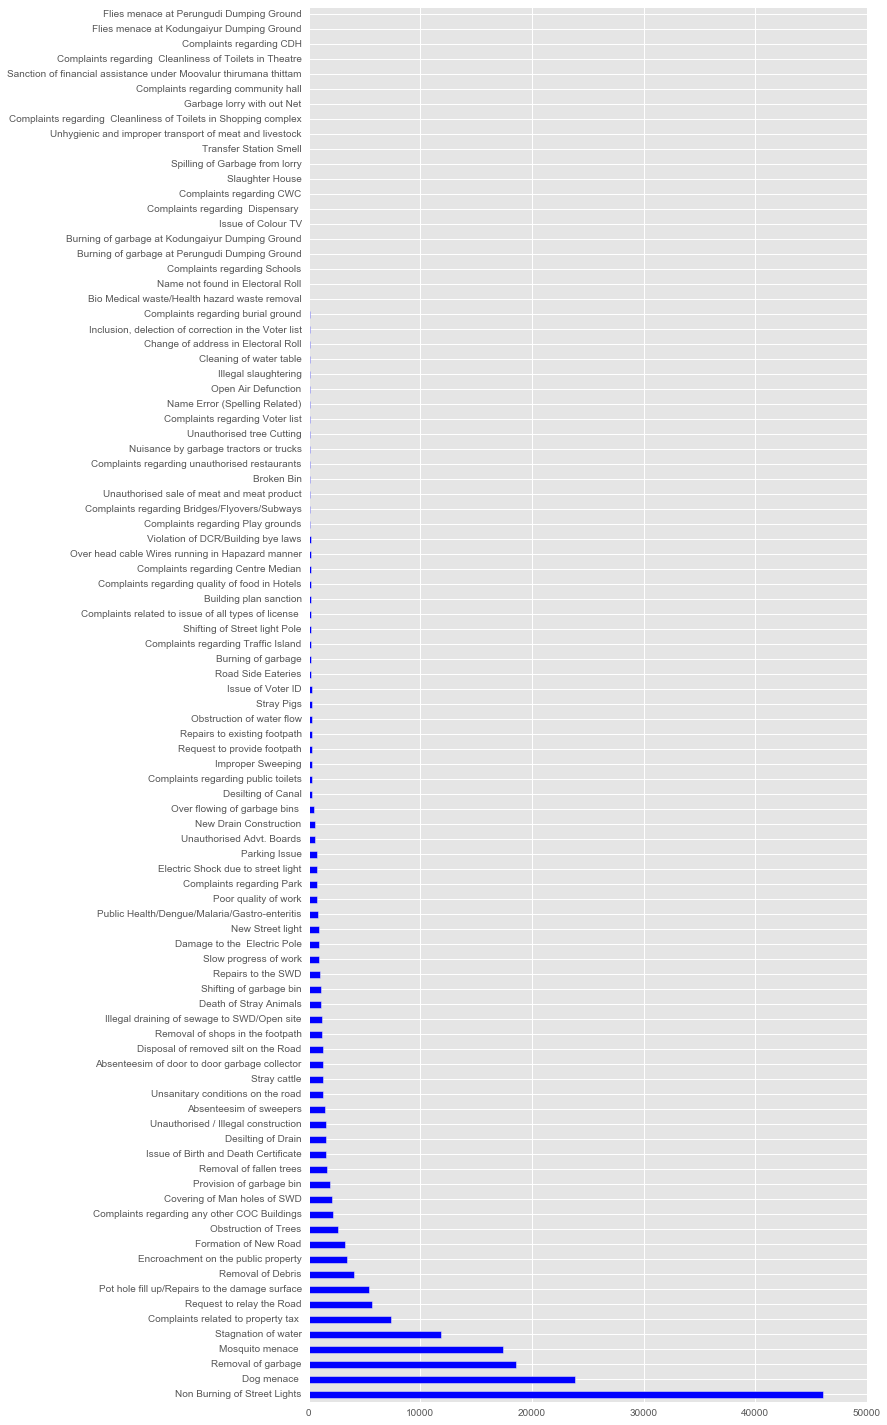

In [11]:
df["Complaint.Type"].value_counts().plot(kind="barh", figsize=(10, 25))

In [12]:
df["Complaint.Date"].head()

# Convert date types 
dateFormat = "%m/%d/%Y %H:%M:%S"
df["Complaint.Date"] = pd.to_datetime(df["Complaint.Date"], format=dateFormat)
df["Resolution.Date"] = pd.to_datetime(df["Resolution.Date"], format=dateFormat)

# add additional columns from the date columns for easier processing
df["Complaint.Year"] = df["Complaint.Date"].apply(lambda _ : _.year)
df["Complaint.Month"] = df["Complaint.Date"].apply(lambda _ : _.month)
df["Complaint.Day"] = df["Complaint.Date"].apply(lambda _ : _.day)
df["Complaint.Hour"] = df["Complaint.Date"].apply(lambda _ : _.hour)

df["Resolution.Year"] = df["Resolution.Date"].apply(lambda _ : _.year)
df["Resolution.Month"] = df["Resolution.Date"].apply(lambda _ : _.month)
df["Resolution.Day"] = df["Resolution.Date"].apply(lambda _ : _.day)
df["Resolution.Hour"] = df["Resolution.Date"].apply(lambda _ : _.hour)

In [13]:
from nltk.stem.porter import PorterStemmer
import nltk.data
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
# The TreeBank word tokenizer
tokenizer = TreebankWordTokenizer()
# Porter Stemmer
stemmer = PorterStemmer()
# common english stop words
stop_words = set(stopwords.words('english')).union([stemmer.stem(sw) for sw in stopwords.words('english')])

def tokenize(text):
    sentences = sent_detector.tokenize(text.lower())
    tokens = []
    for sentence in sentences:
        # tokenize
        toks = tokenizer.tokenize(sentence)
        # strip and stem the words
        tokens.extend(map(lambda x: stemmer.stem(x.strip()), toks))    
    # filter out non-alphanumeric words i.e punctuation and remove stop words    
    return filter(lambda x: x.isalnum() and x not in stop_words, tokens)


def tokenizeColumn(df, inputColumnName, outputColumnName):
    # to deal with python's damned $*@&# unicode issues
    df.tempColumn = df[inputColumnName].apply(lambda _: unicode(str(_), "utf-8"))
    df[outputColumnName] = df.tempColumn.apply(tokenize)
    

In [14]:
smallDf = df.head(1000)
tokenizeColumn(smallDf, "Complaint.Details", "Complaint.DetailsTokenized")

/home/hduser/workspaces/datakind-workspace/egovernments/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
smallDf["Complaint.DetailsTokenized"].head()

0                       [pleas, rectifi, problem, sir]
1    [remit, tax, arrear, rs, 4522, via, citi, bank...
2    [pleas, catch, stray, cattl, problem, sir, ple...
3               [mani, dog, kindli, take, action, sir]
4                            [pleas, rectifi, problem]
Name: Complaint.DetailsTokenized, dtype: object

In [16]:
def computeJaccardIndex(df, idColumn, columnName):
    jaccard = {}
    for i, row1 in zip(df[idColumn], df[columnName]):
        jaccard[i] = {}
        for j, row2 in zip(df[idColumn], df[columnName]):            
            v1 = set(row1)
            v2 = set(row2)
            if len(v1) == 0 or len(v2) == 0:
                continue
            jaccard[i][j] = float(len(v1.intersection(v2))) / len(v1.union(v2))
    return jaccard
# this takes a long time
#jaccard = computeJaccardIndex(smallDf, "Unnamed: 0", "Complaint.DetailsTokenized")
jaccard = {}

In [17]:
done = set()
writer =  open("first100Results.csv", "w")
for id1, jacDict in jaccard.iteritems():
    for id2, value in jaccard[id1].iteritems():
        idSet = "_".join(sorted([str(id1), str(id2)]))        
        if value > 0.80 and id1 != id2 and idSet not in done:            
            done.add(idSet)    
            writer.write("{},{},{},\"{}\",\"{}\"\n".format(value, id1, id2,
                   smallDf[smallDf["Unnamed: 0"] == id1]["Complaint.Details"].values[0].replace("\n", "\\n"), 
                   smallDf[smallDf["Unnamed: 0"] == id2]["Complaint.Details"].values[0].replace("\n", "\\n")))
writer.close()
            

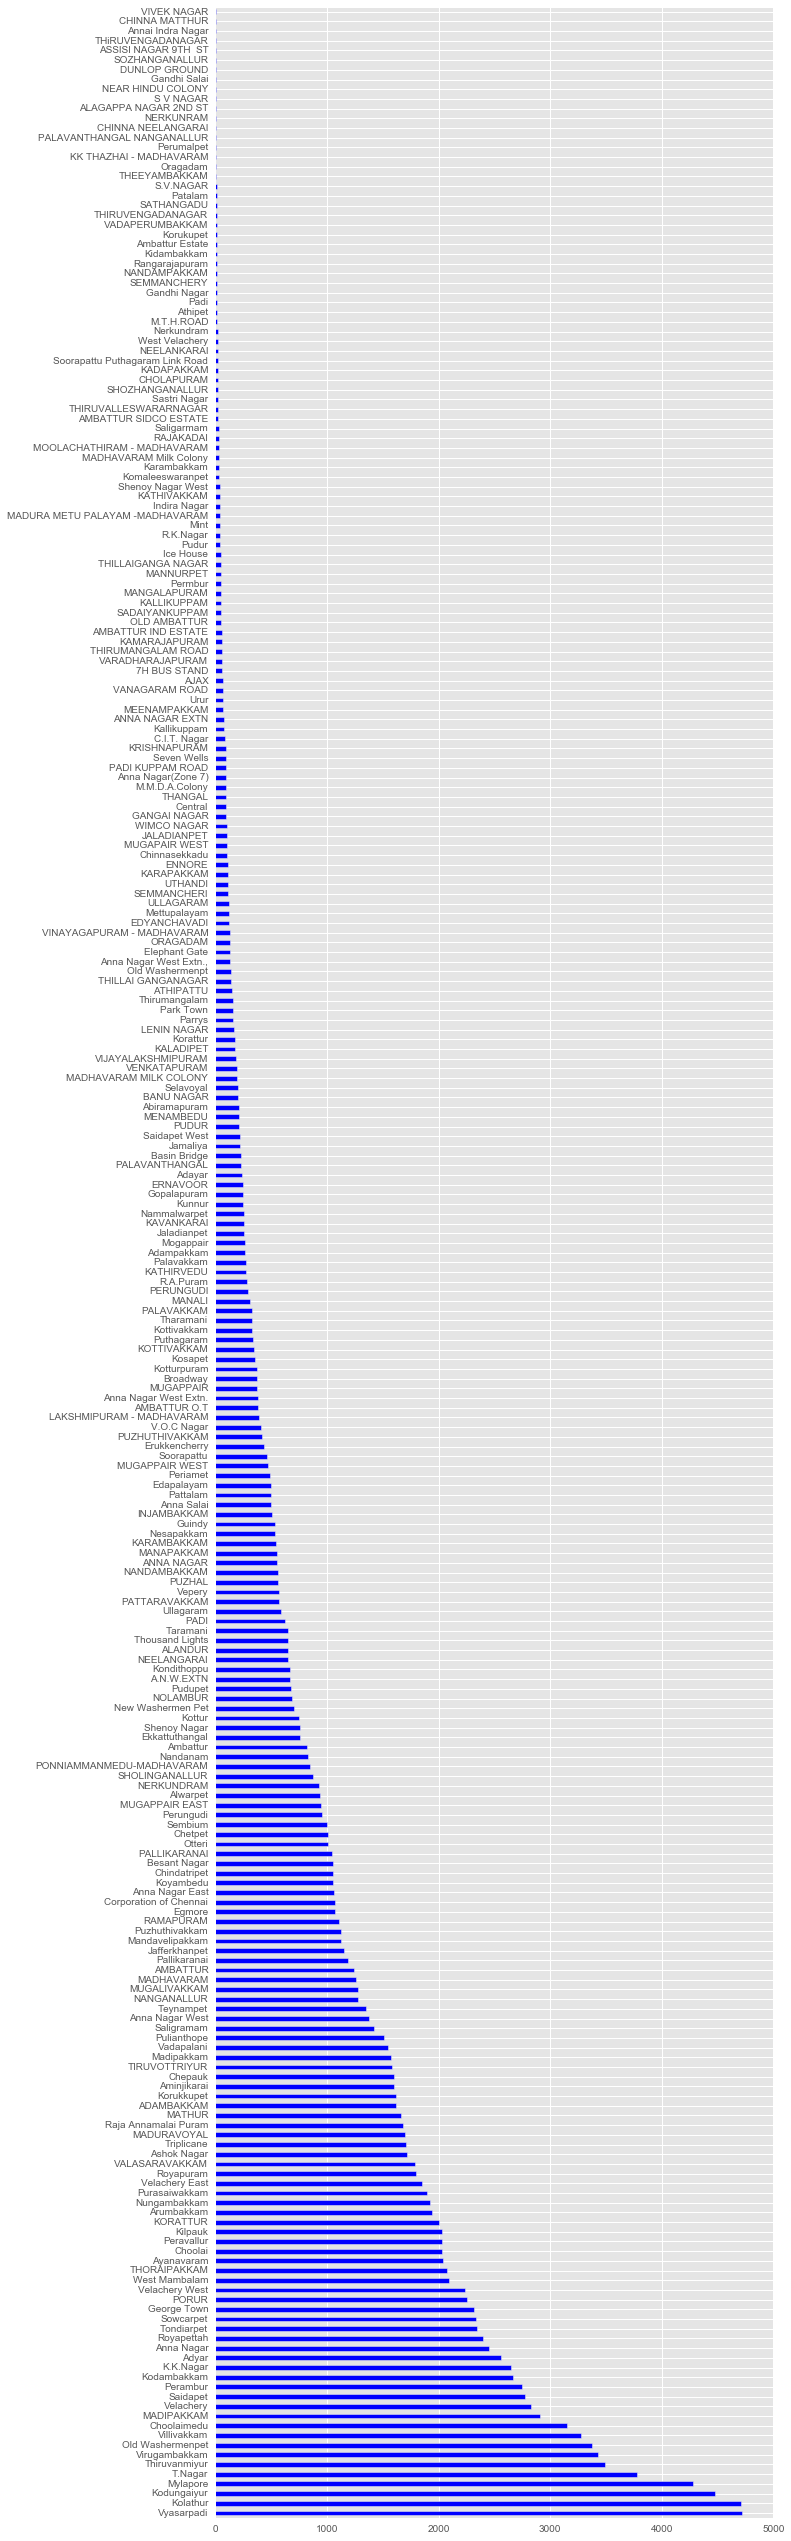

In [18]:
df["Area"].value_counts().plot(kind="barh", figsize =(10, 45))

In [19]:
print np.unique(df["Locality"]).shape
print "nan" in np.unique(df["Locality"])

(3392,)
False


/home/hduser/workspaces/datakind-workspace/egovernments/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [20]:
print np.unique(df["Street"]).shape
print "nan" in np.unique(df["Street"])

(21522,)
False


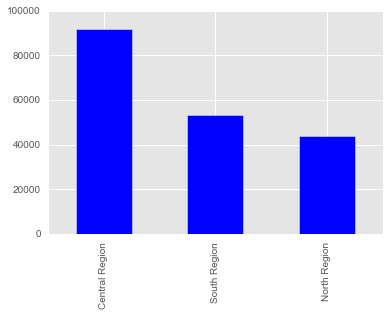

In [21]:
df["Region"].value_counts().plot(kind="bar")

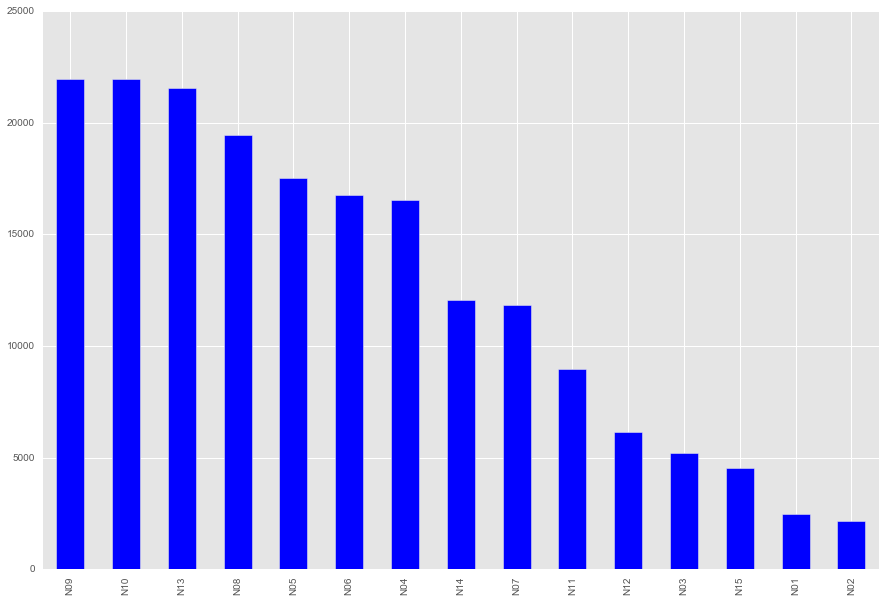

In [22]:
df["Zone"].value_counts().plot(kind="bar", figsize=(15, 10))

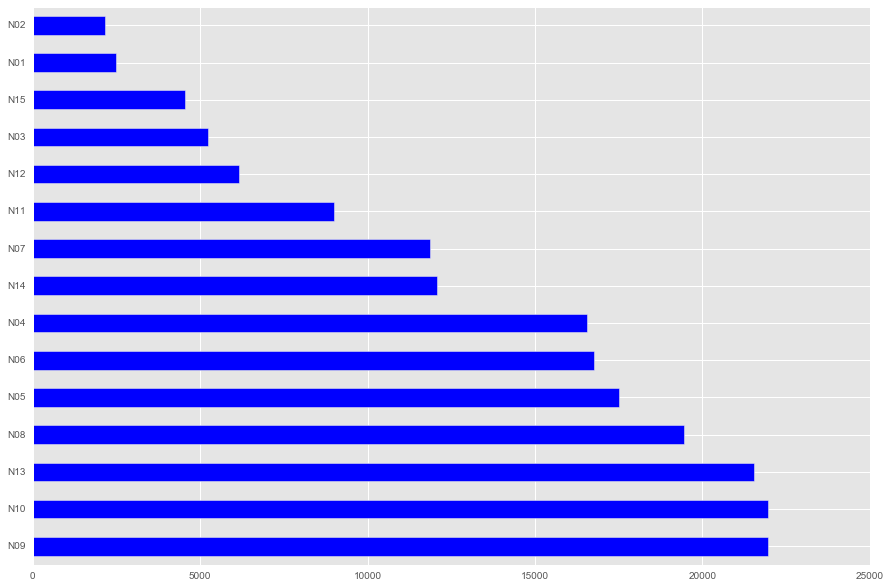

In [23]:
df["Zone"].value_counts().plot(kind="barh", figsize = (15, 10))

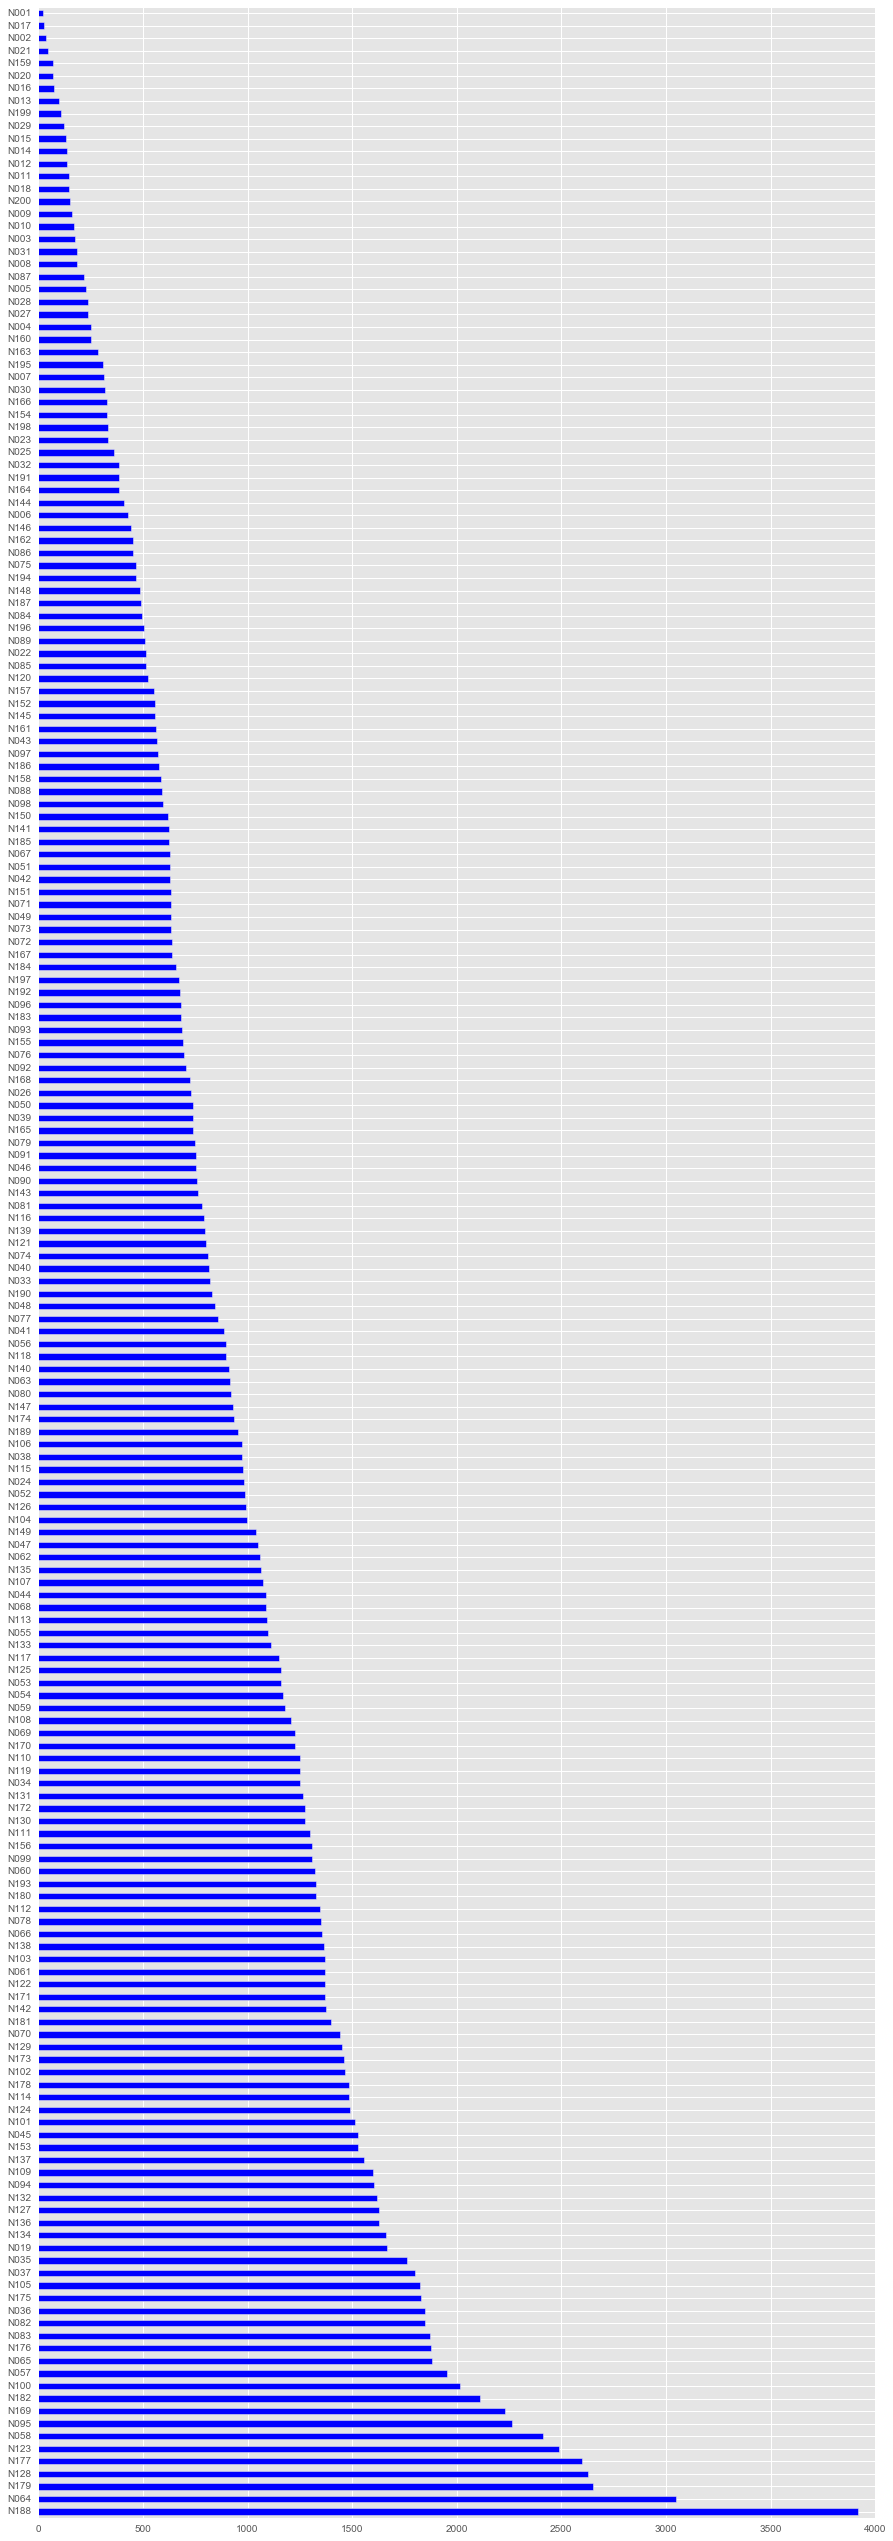

In [24]:
df["Ward"].value_counts().plot(kind = "barh", figsize = (15, 45))

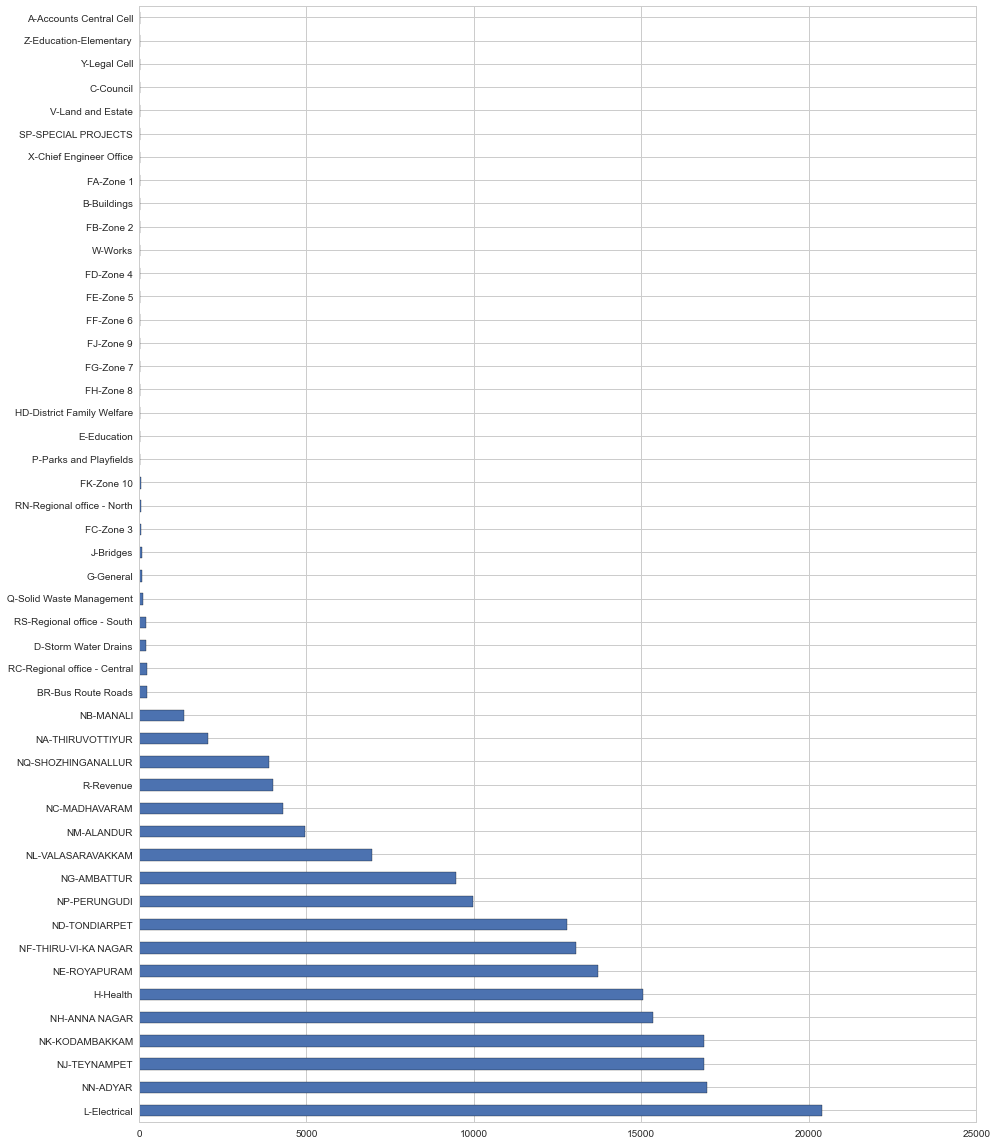

In [274]:
df["Department"].value_counts().plot(kind="barh", figsize=(15, 20))

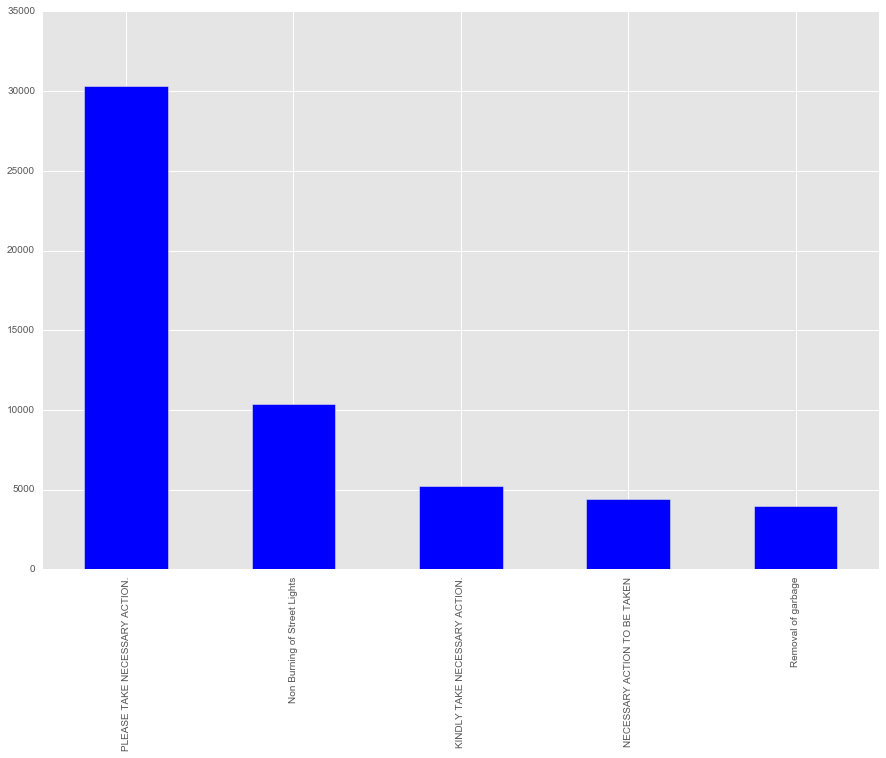

In [25]:
df["Complaint.Details"].value_counts()[:5].plot(kind="bar", figsize = (15, 10))

In [26]:
df["Email"].value_counts()[:10]

00e3902431681886db4cf60de2db9188                                    142886
8f726df8b243f23cc2a390bbc488b6c8ce90f5584fecab71074fa56af2002f02       186
2866e9e7f174ecdbaf23dd3dcf561121ed21894411f42e8d0303cb38262e19c3        78
26a1921d5824ab725de0bdc2a4927a7b27006eefbb74307389e3c3d7a69f5c26        64
a241067362863c8f0cba05034d84aefe748277888efe70252dd61cf102c482cd        62
8537ff31415c3b731e4dbba9963a22726a1f9c8a75674934832ab05f04ec0cdd        60
37d4bd827c26262a4e7bb528ae26f8ae8cc5f0a0ca14f09278453c87dec21d3b        57
7af6b3908e04a60ddb979db9d35561e7fcaffed2b0288d4f810d47b88929a7b4        56
96708de8314bd287d00401fe94b572111c70f418a7aea7ccb570e451753265e7        55
6f35e3ba4e468b4a1e988b62b02c148edfc3b1c1223b1b4656e03ec6b253f53c        53
Name: Email, dtype: int64

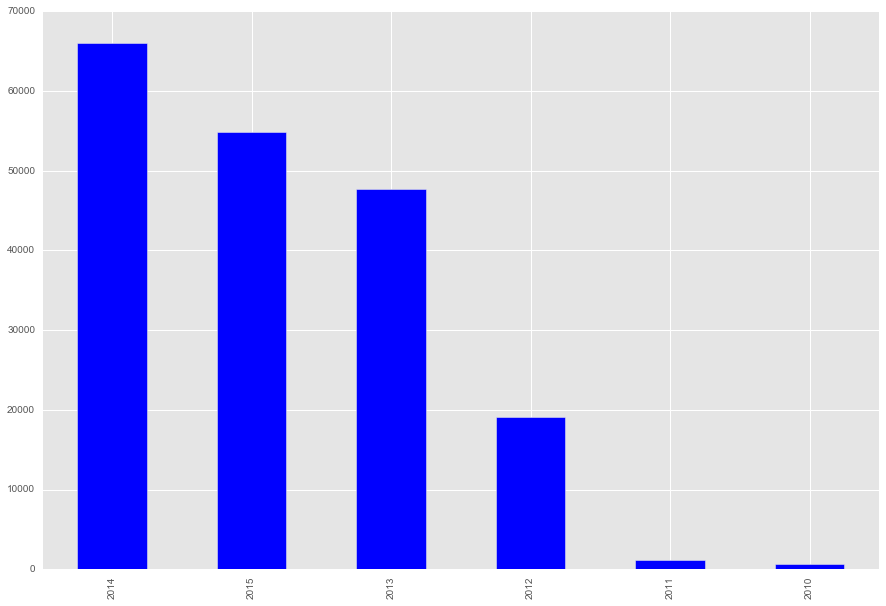

In [27]:
df["Complaint.Year"].value_counts().plot(kind="bar", figsize=(15,10))

/home/hduser/workspaces/datakind-workspace/egovernments/local/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


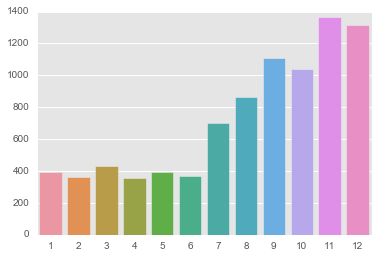

In [28]:
complaintType = "Dog menace "
year = 2014
c = collections.Counter(df[(df["Complaint.Type"] == complaintType) & (df["Complaint.Year"] == year)]["Complaint.Month"])
sns.barplot(np.array(map(itemgetter(0), c.items())),
        np.array(map(itemgetter(1), c.items())))

In [126]:
def plotComplaintType(df):
    for complaintType in df["Complaint.Type"].unique():
        for year in df["Complaint.Year"].unique():
            slices = df[(df["Complaint.Type"] == complaintType) & (df["Complaint.Year"] == year)]
            if len(slices) == 0:
                continue
            c = collections.Counter(slices["Complaint.Month"])
            sns.barplot(np.array(map(itemgetter(0), c.items())),
                np.array(map(itemgetter(1), c.items())))
            plt.title("Complaint Type: {}, Year: {}".format(complaintType, year))
            plt.xlabel("Month")
            plt.ylabel("Number of Complaints")
            plt.savefig("{}_{}.png".format(year, complaintType.replace("/", "")), dpi=200)
            plt.clf()

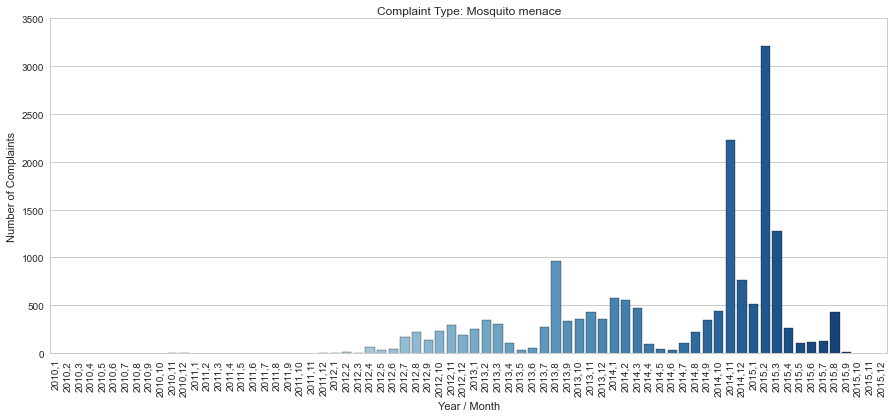

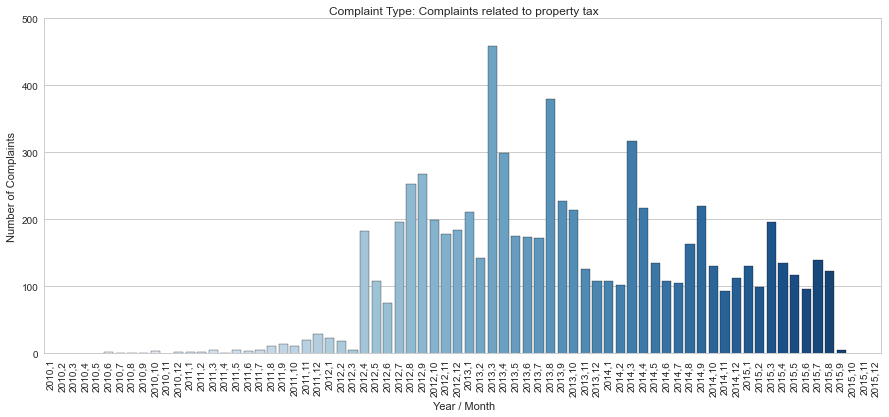

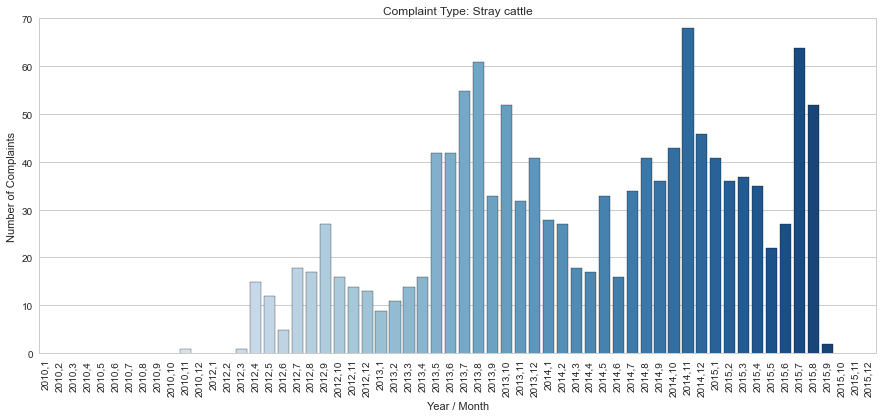

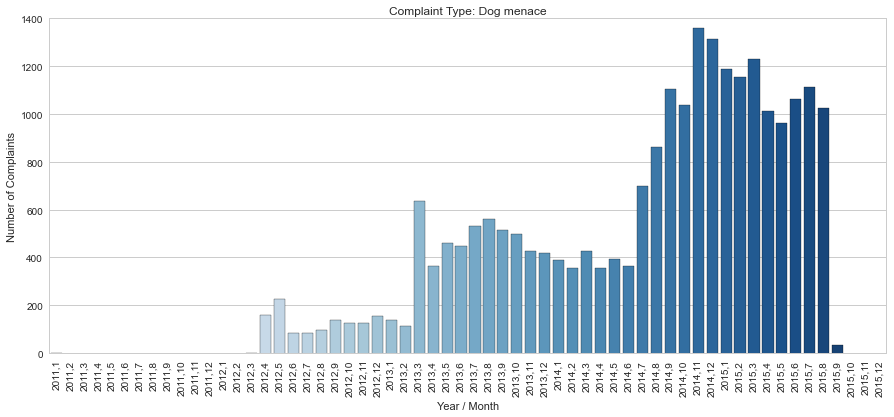

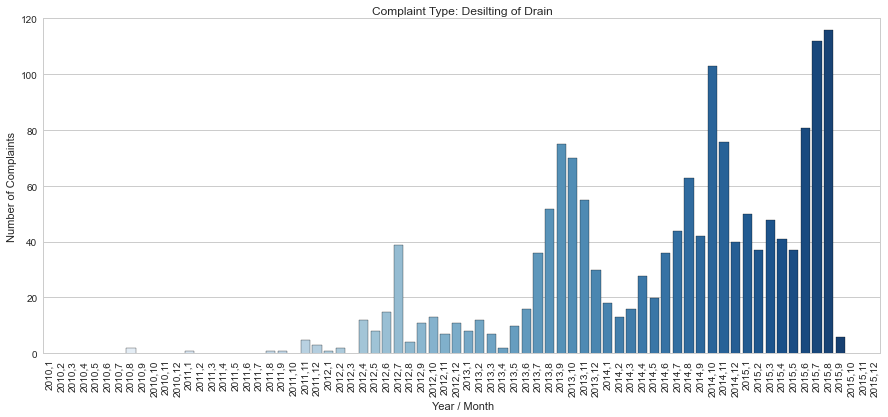

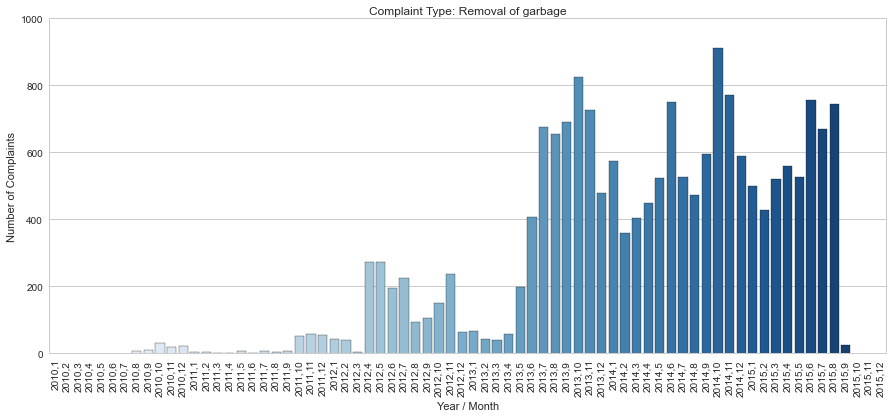

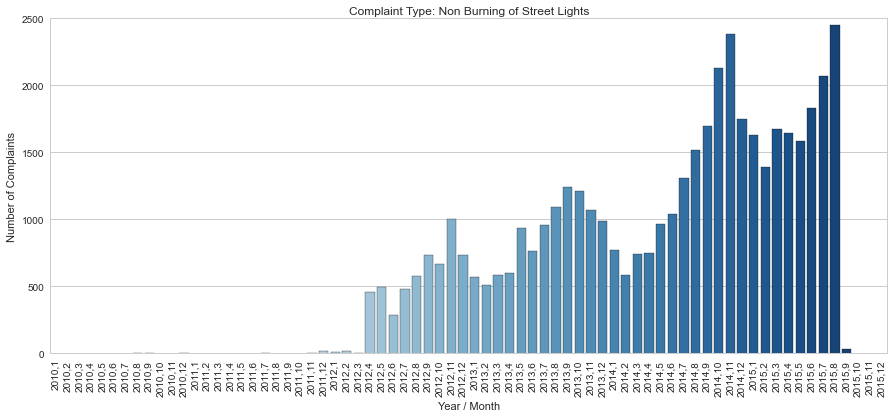

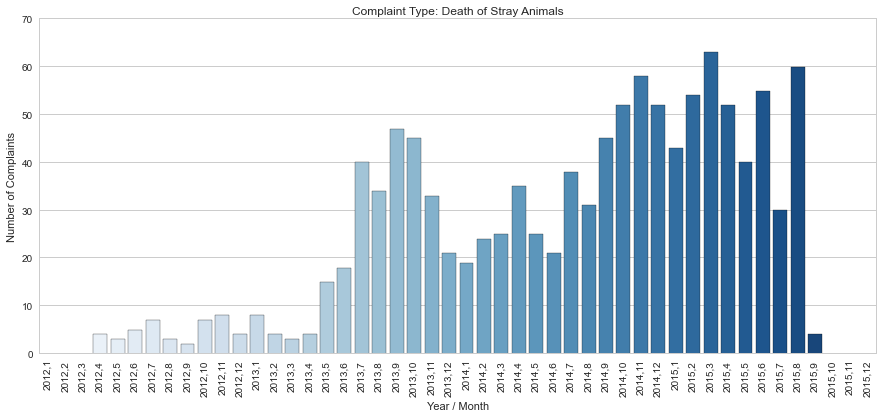

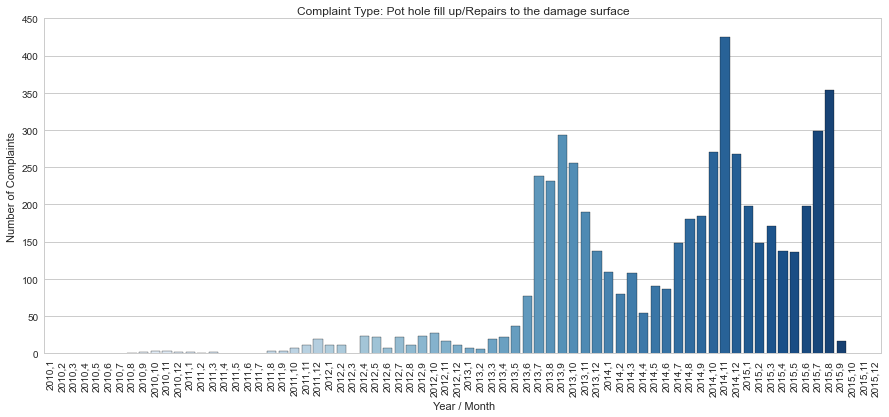

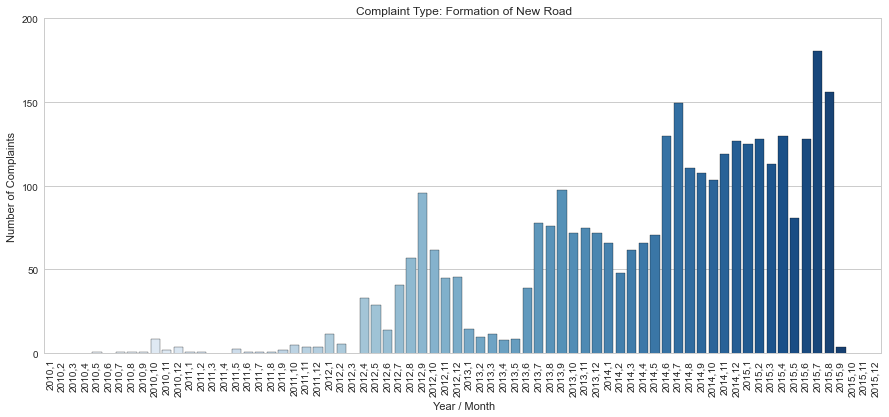

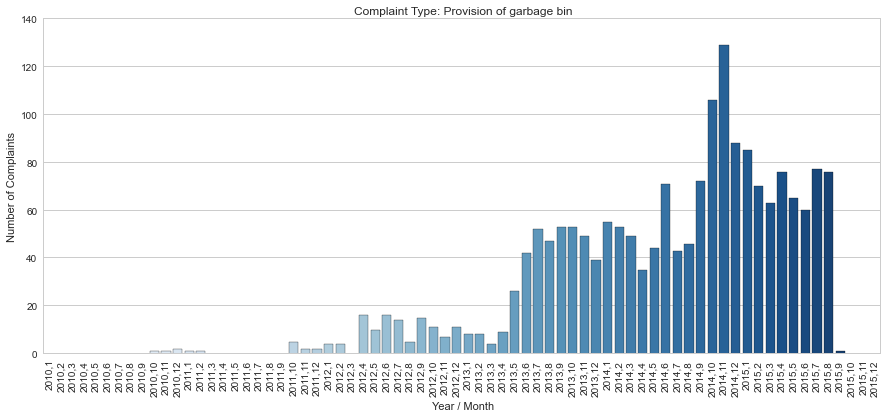

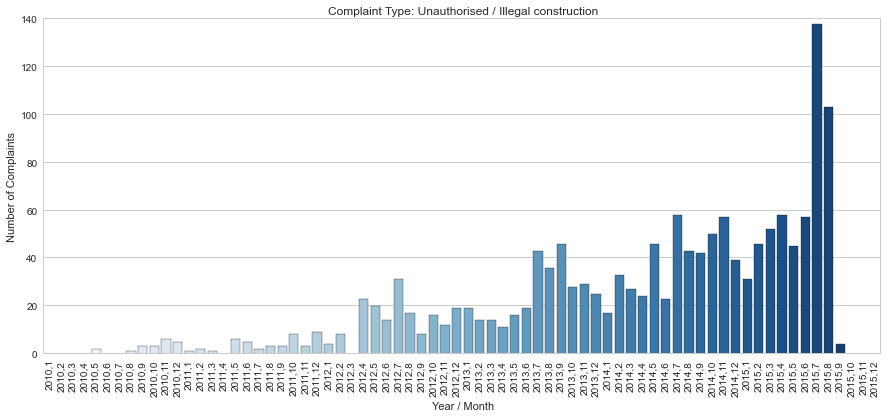

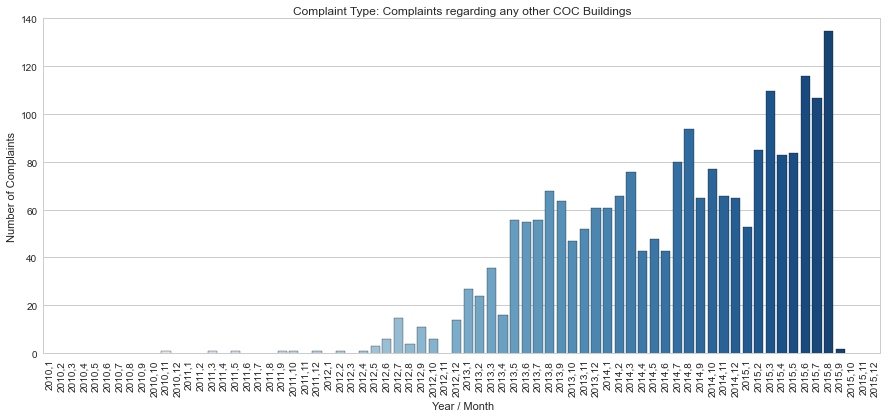

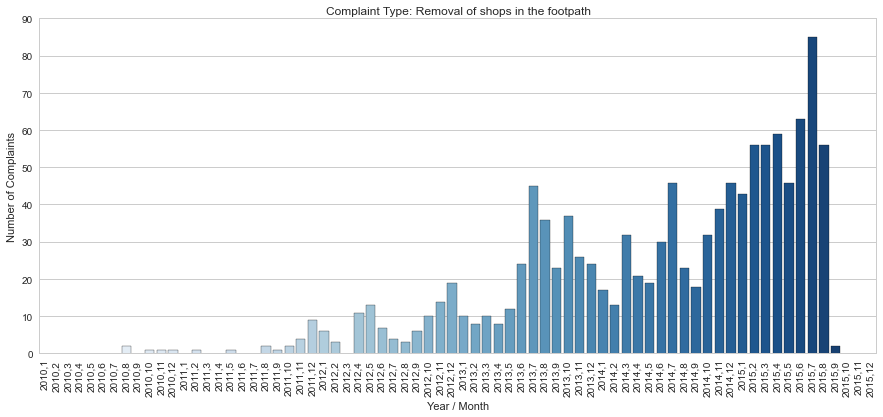

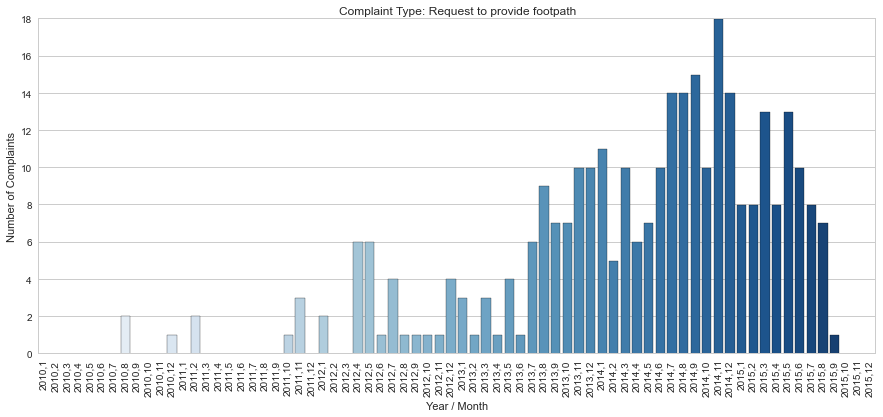

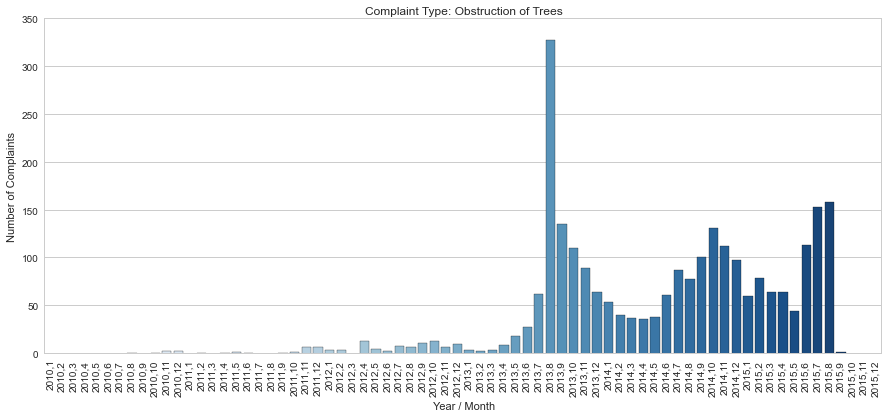

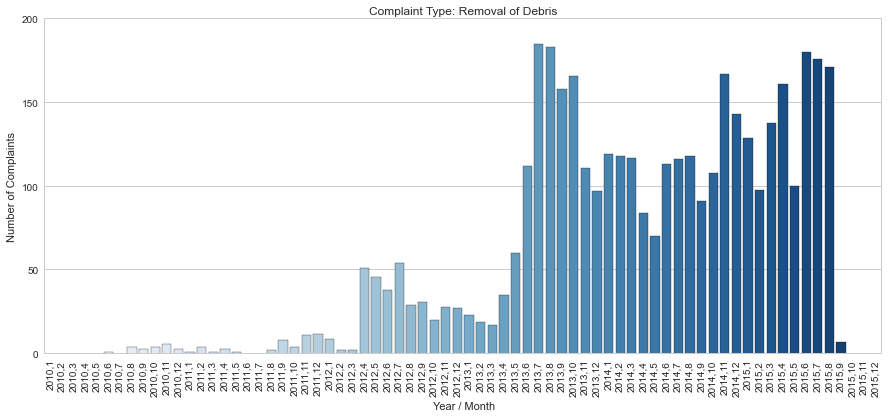

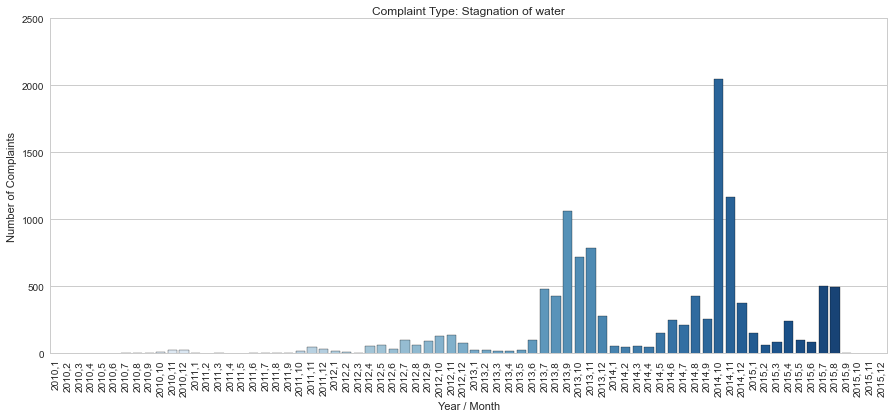

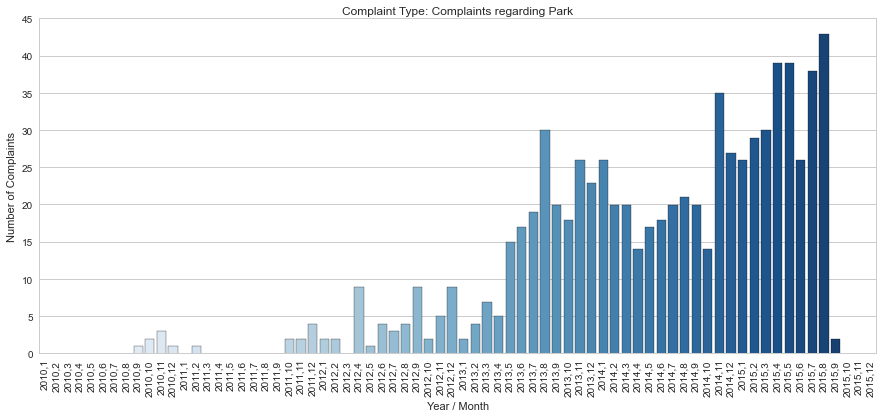

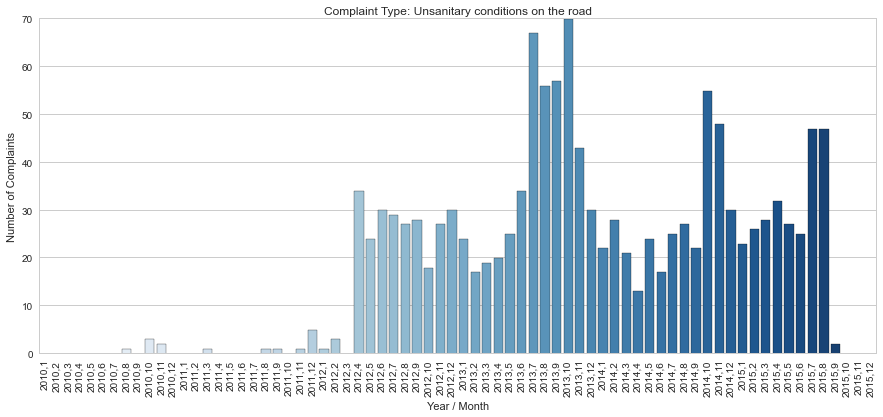

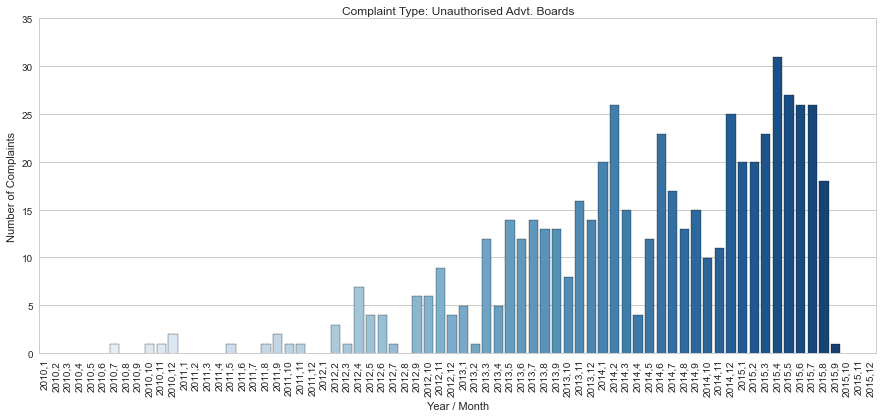

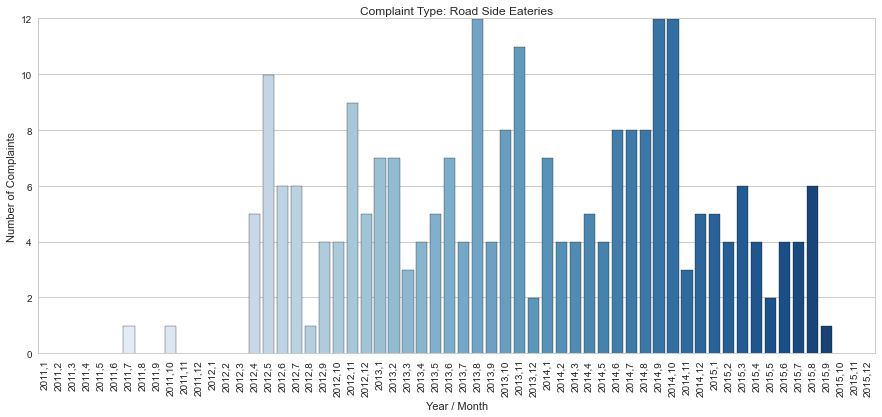

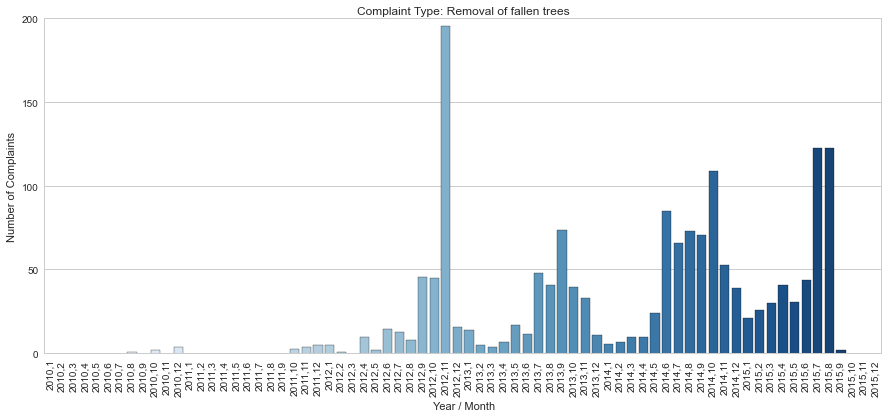

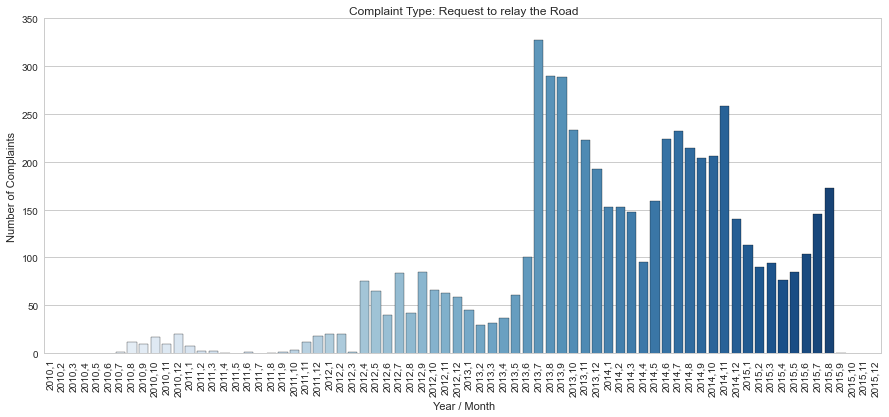

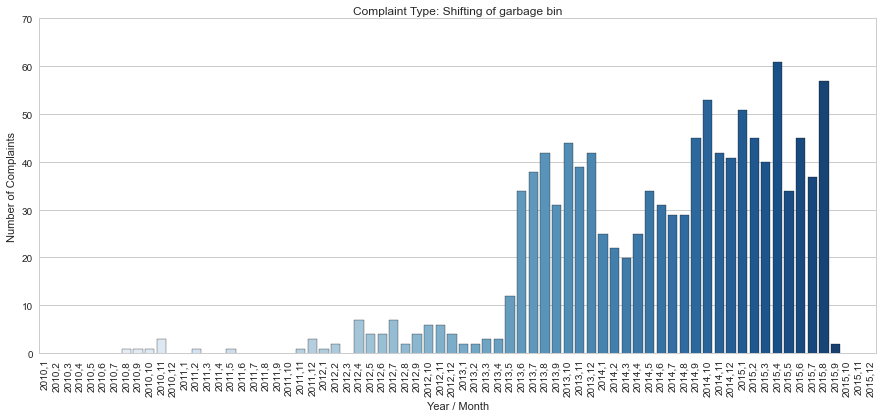

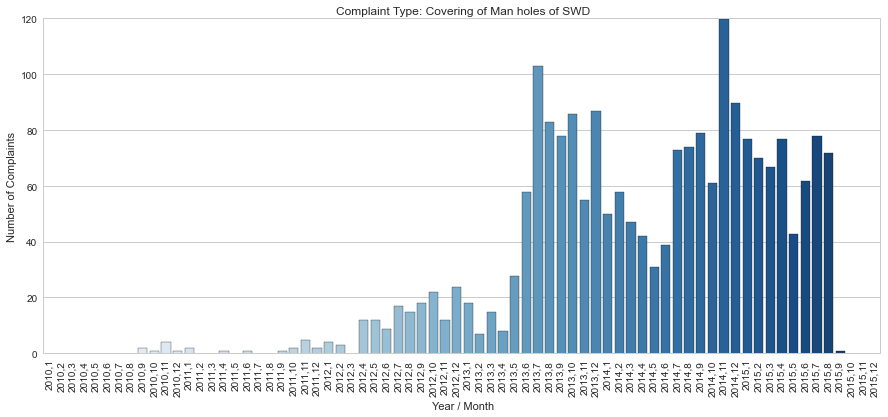

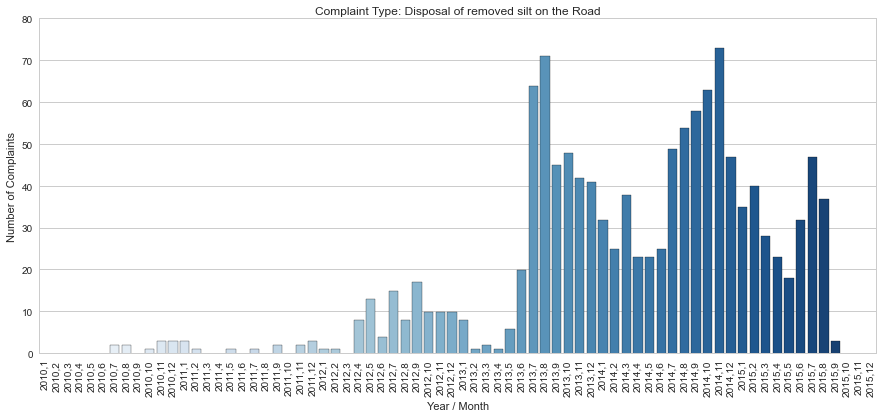

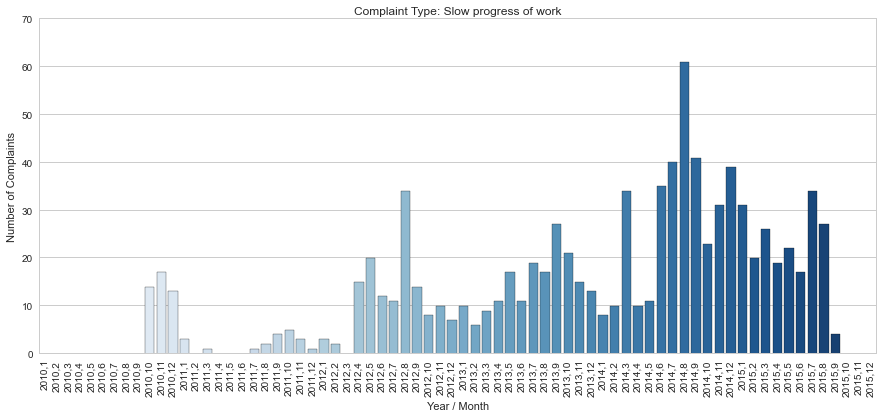

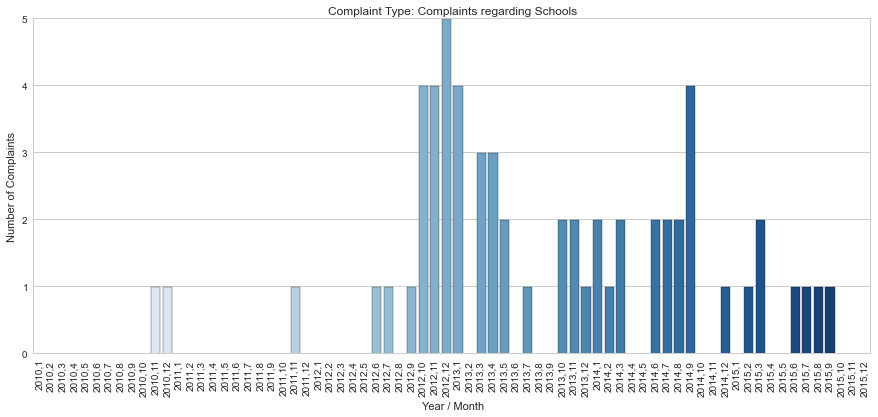

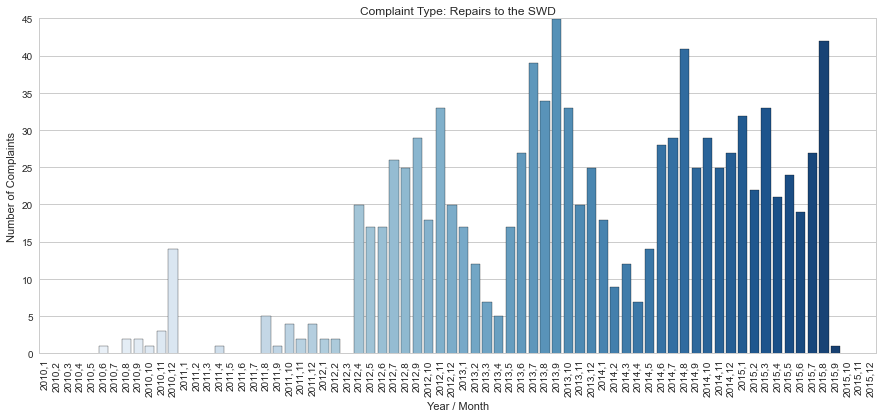

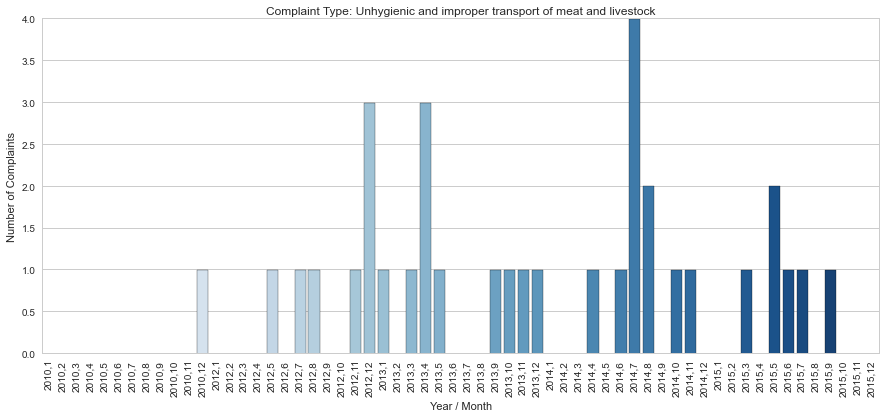

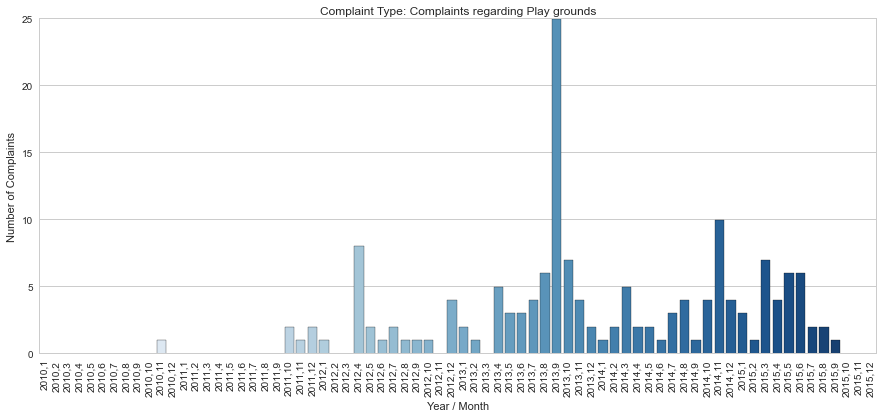

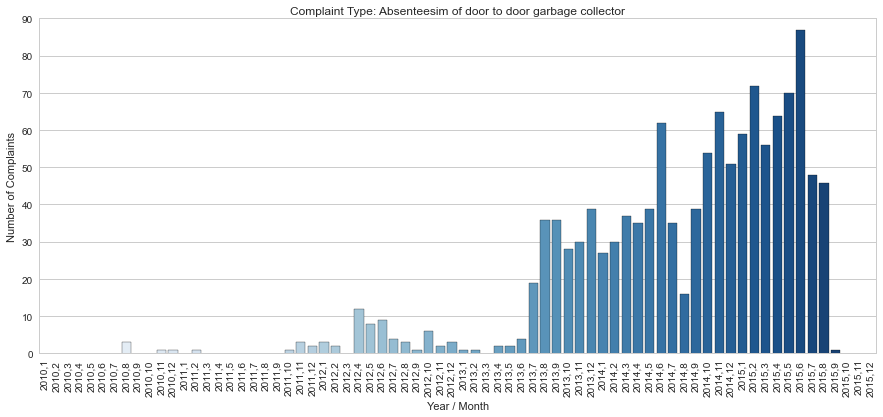

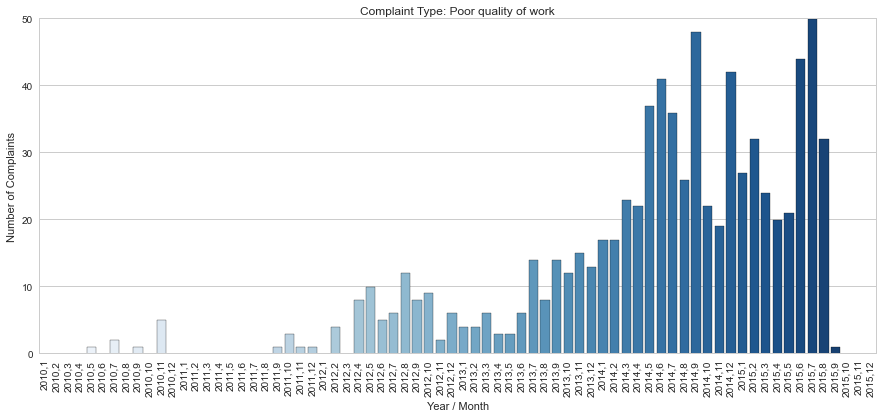

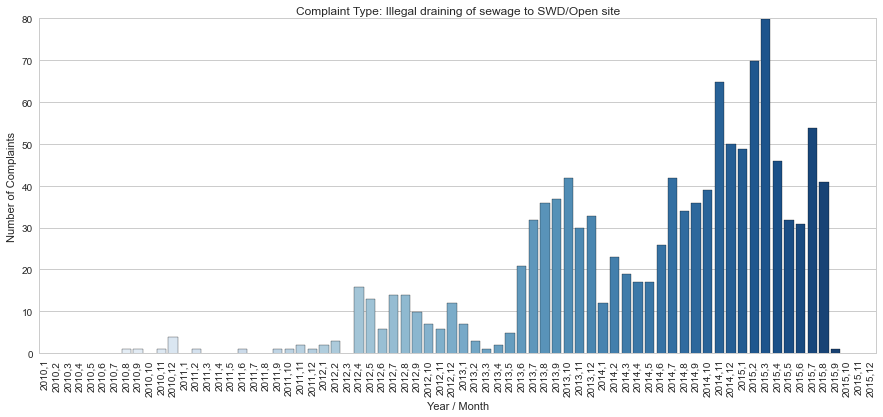

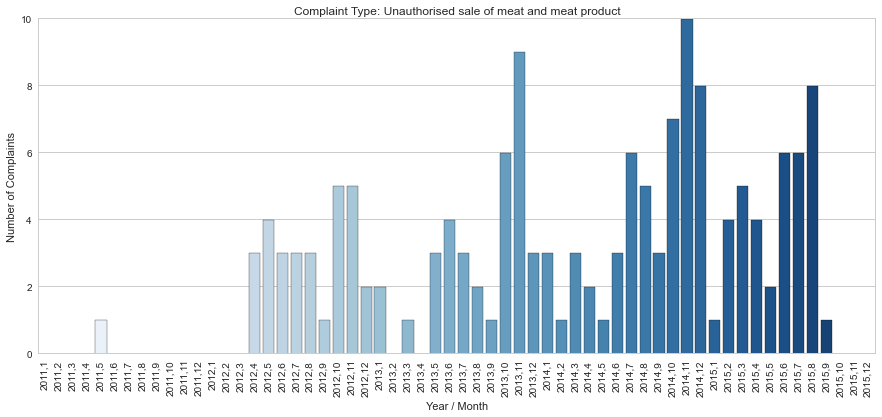

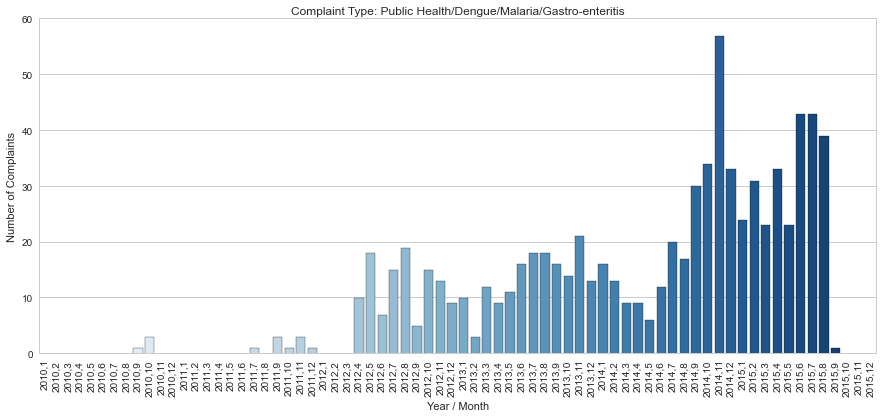

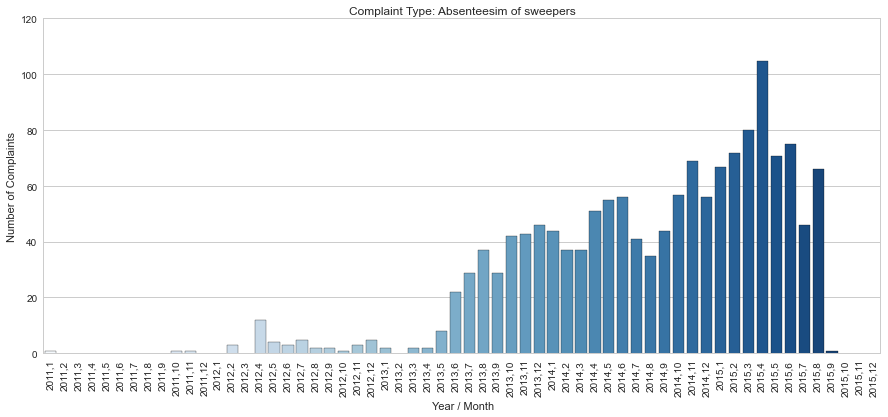

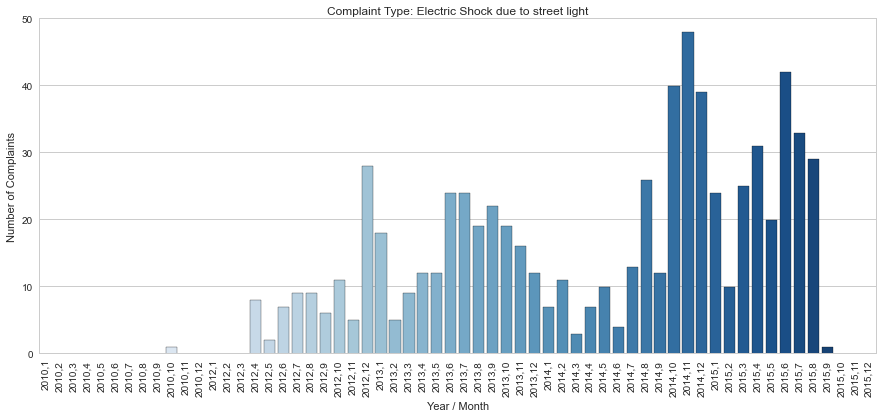

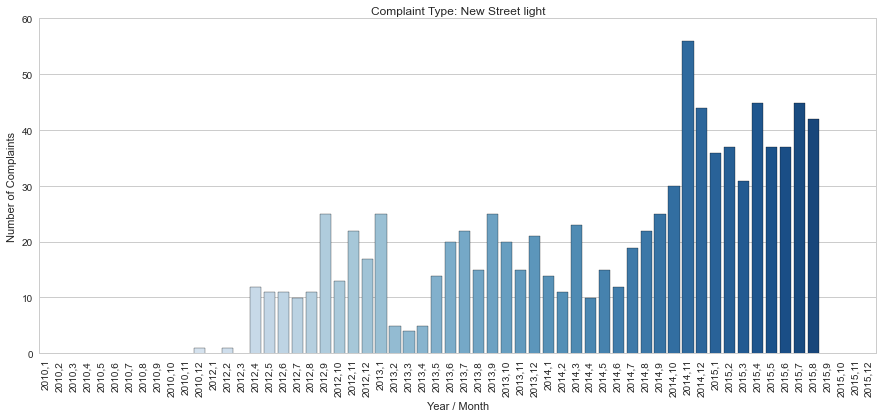

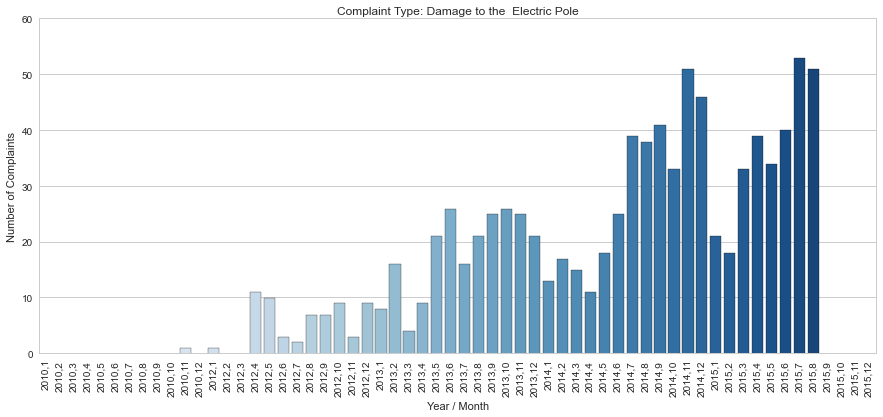

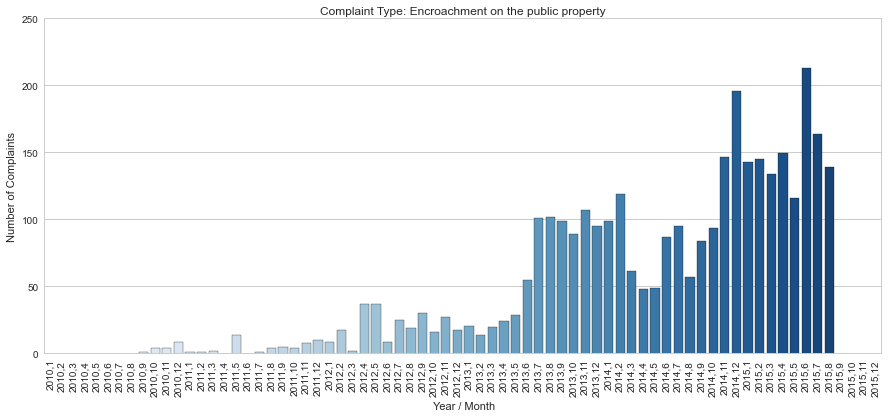

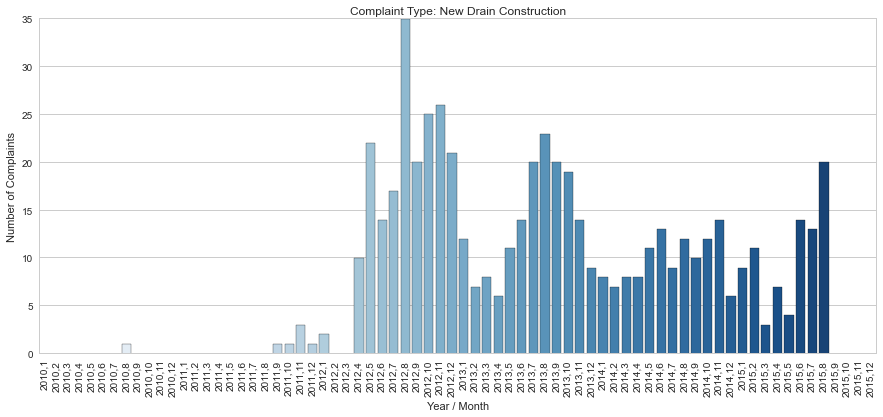

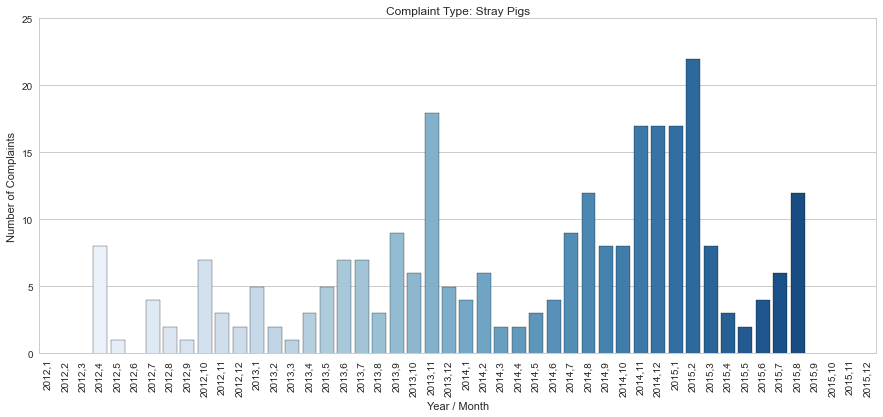

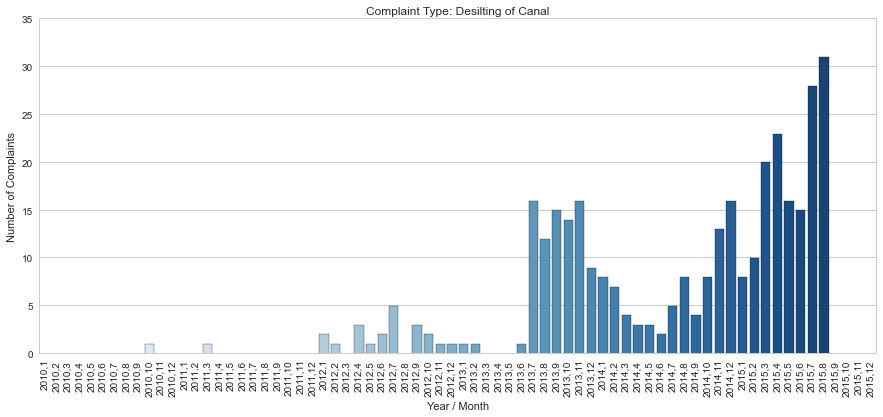

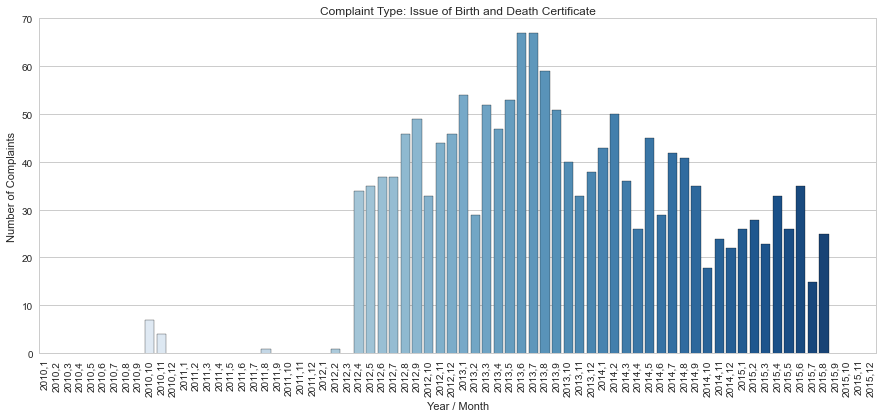

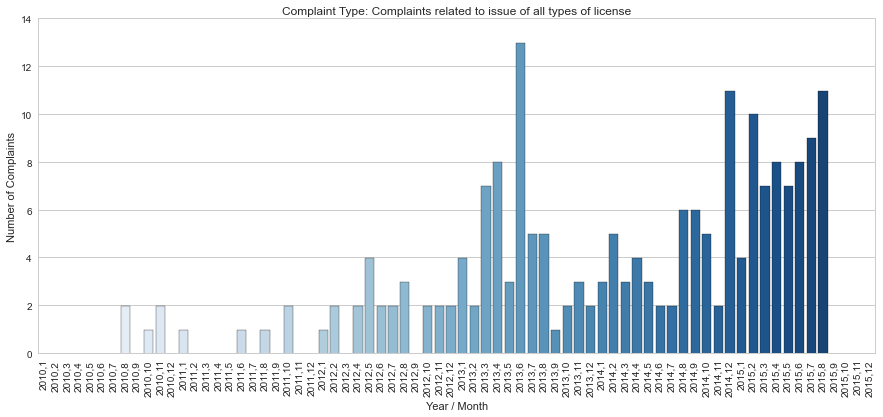

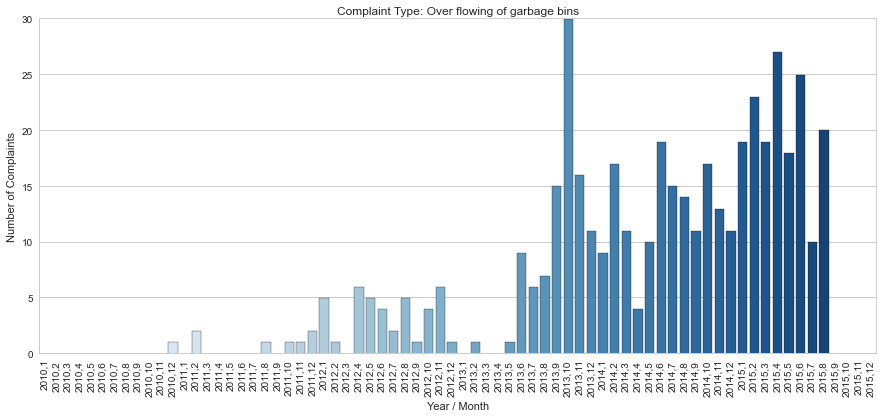

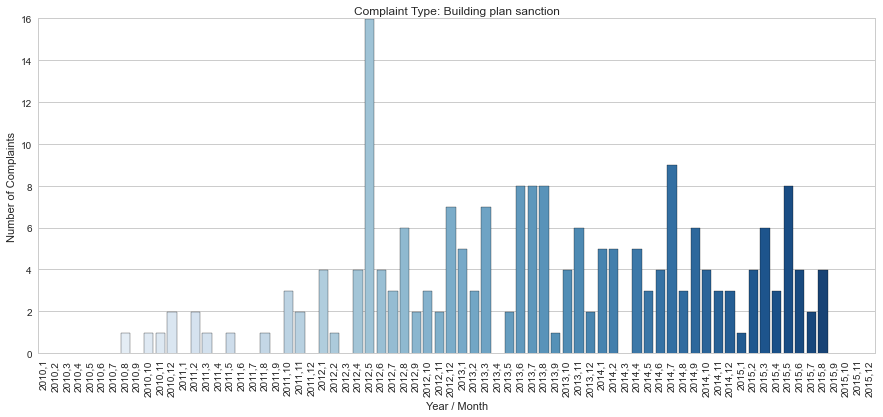

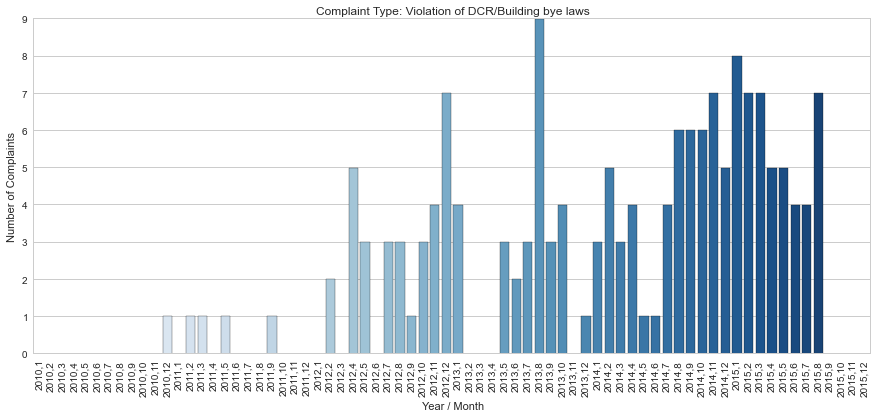

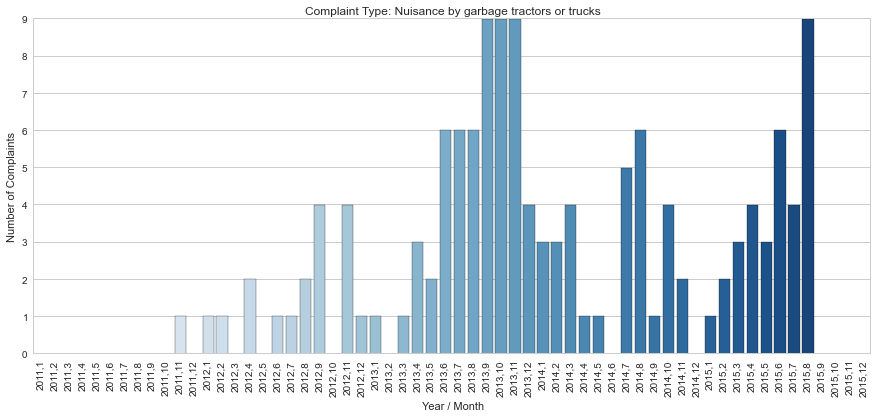

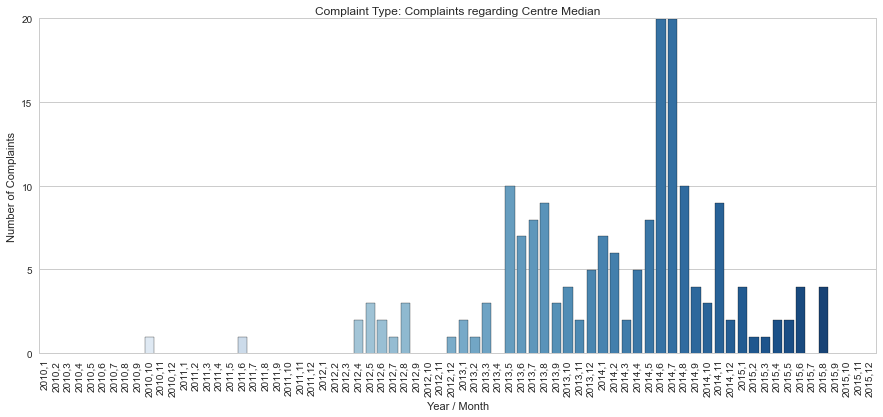

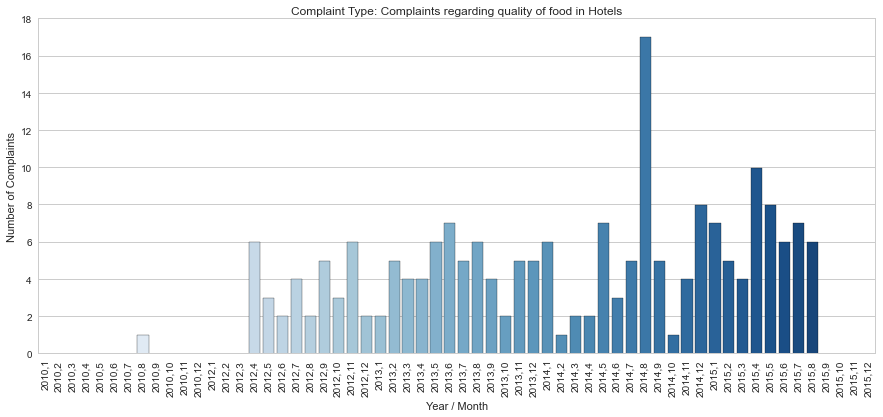

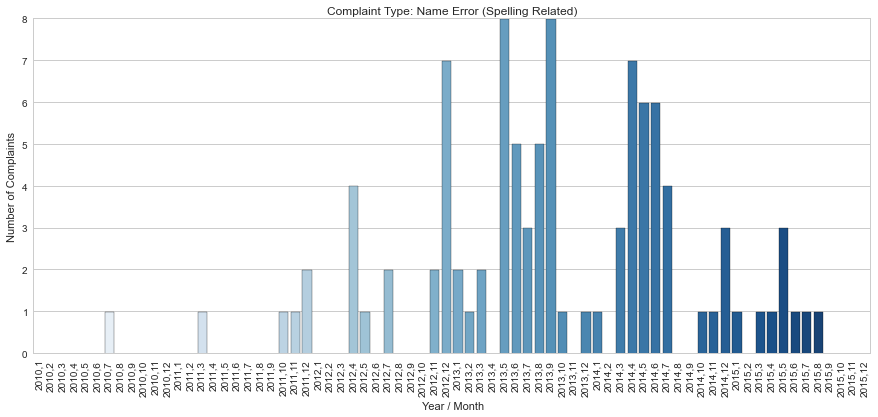

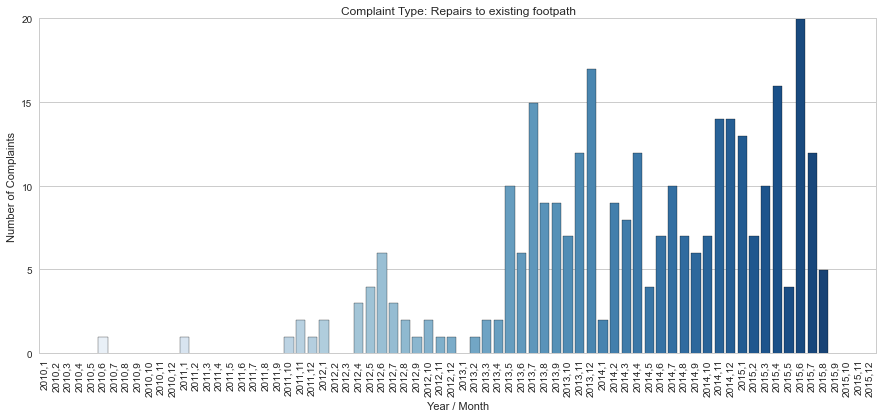

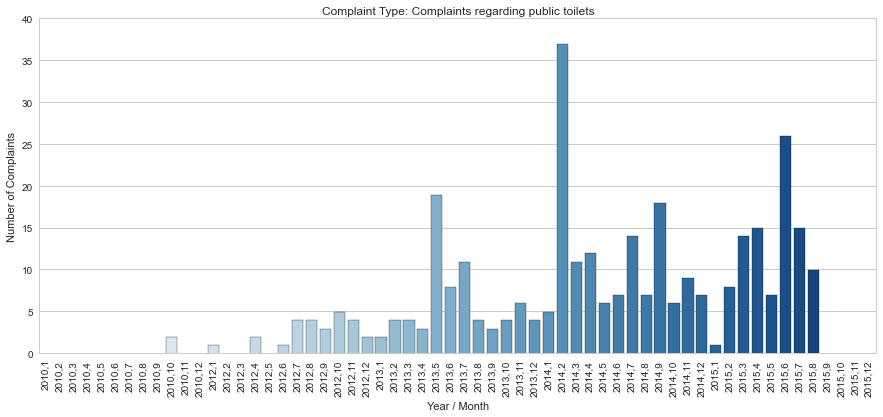

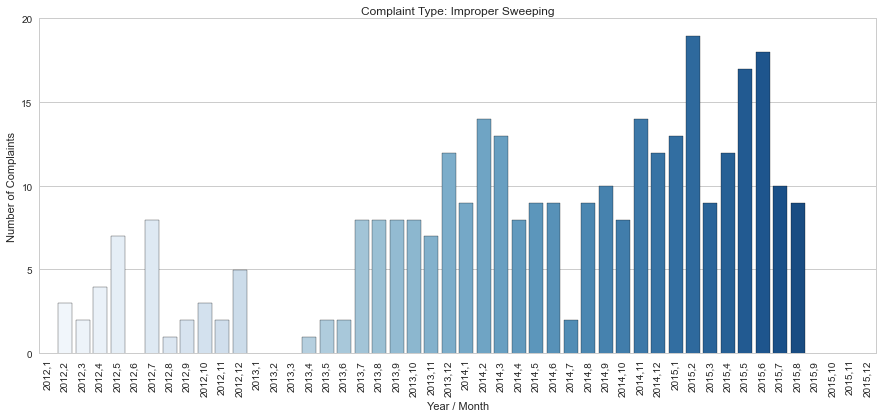

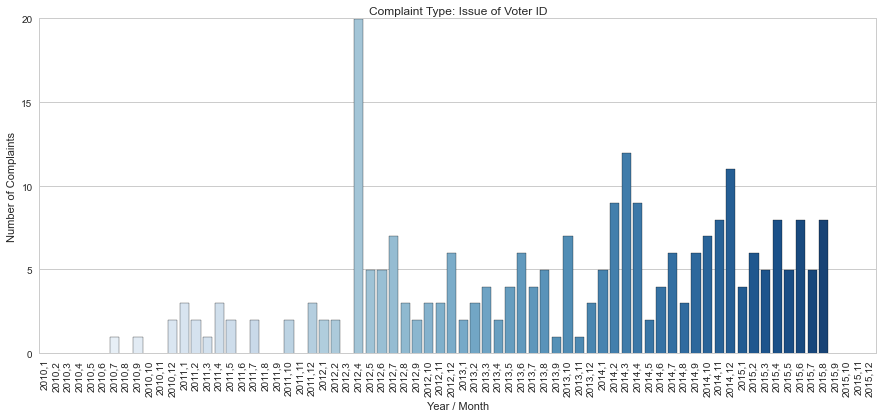

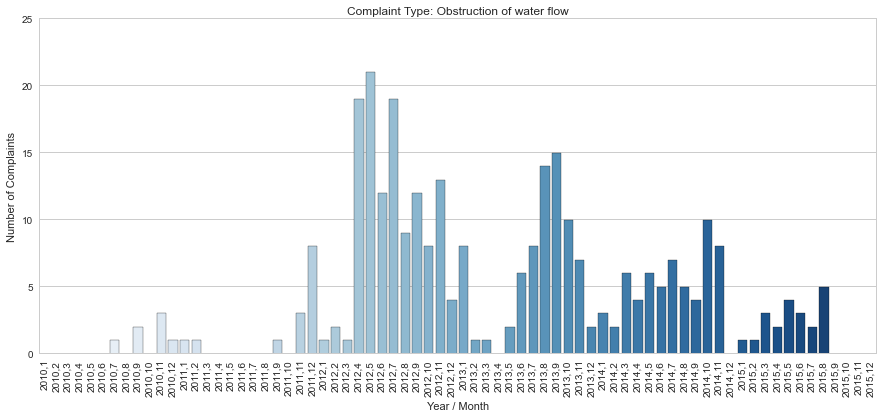

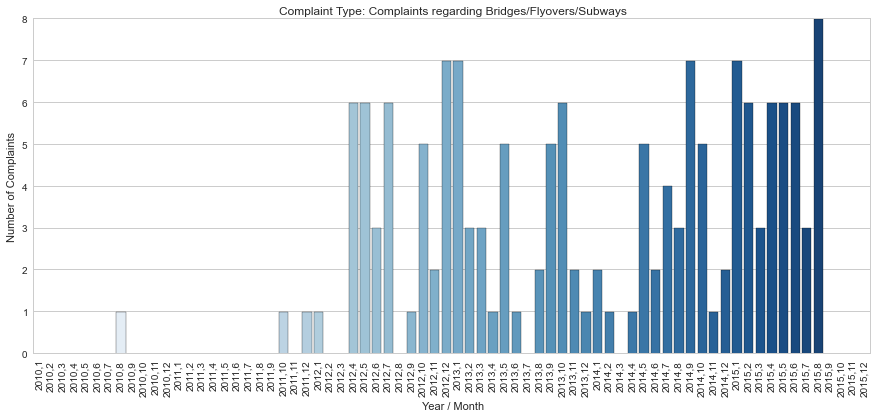

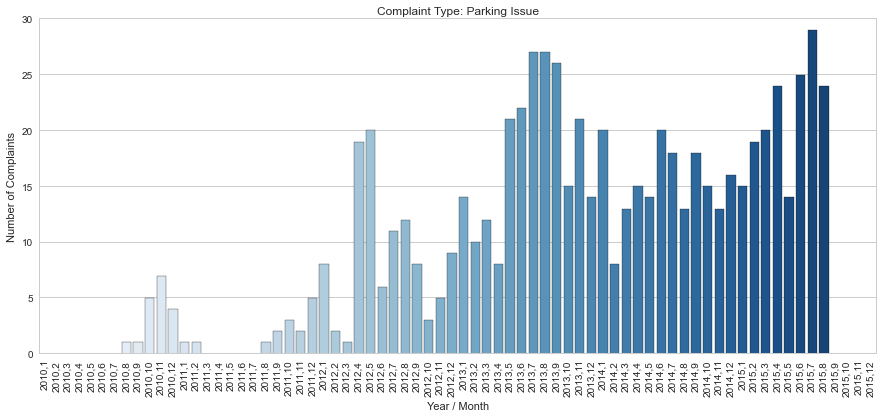

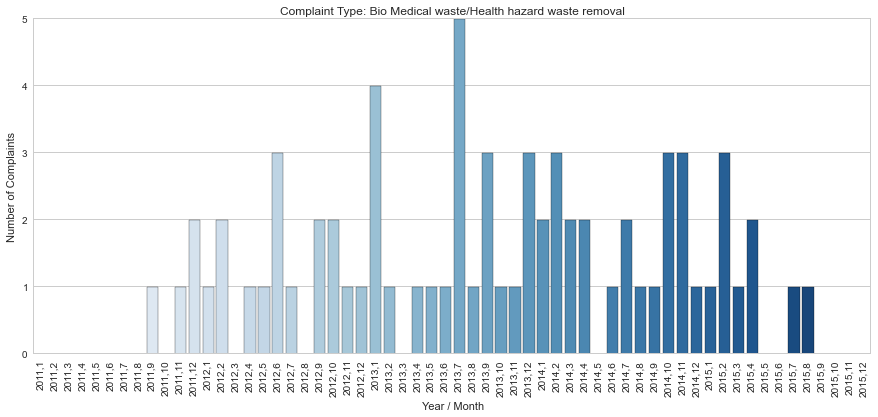

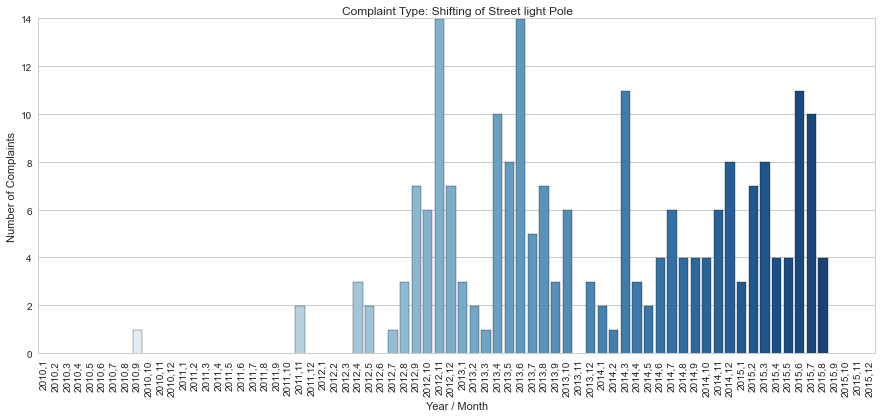

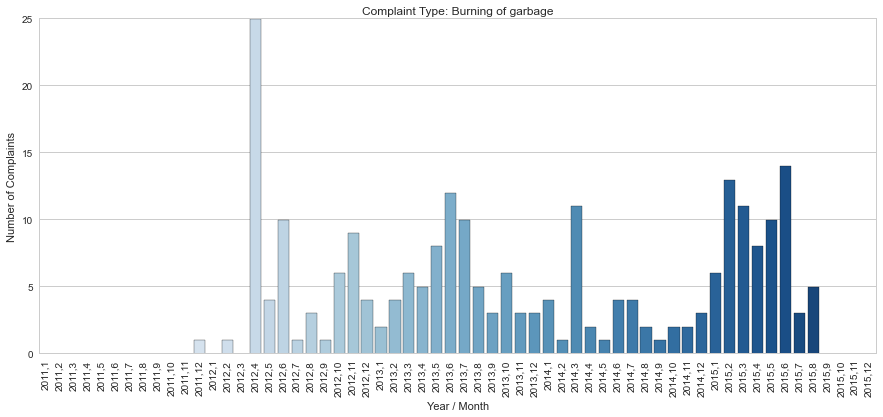

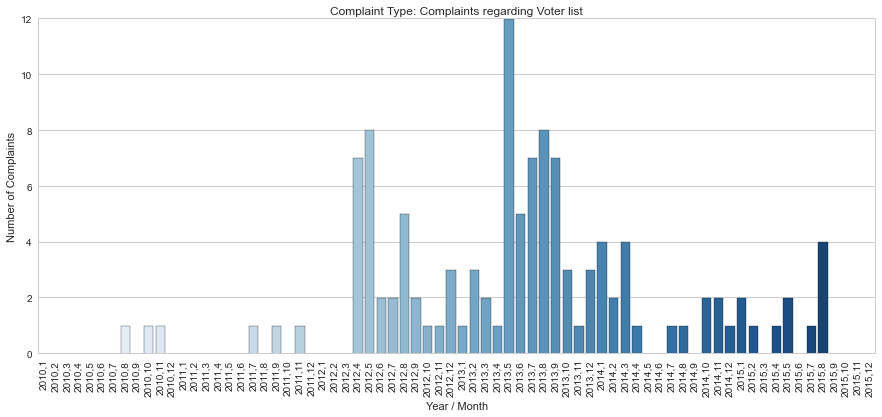

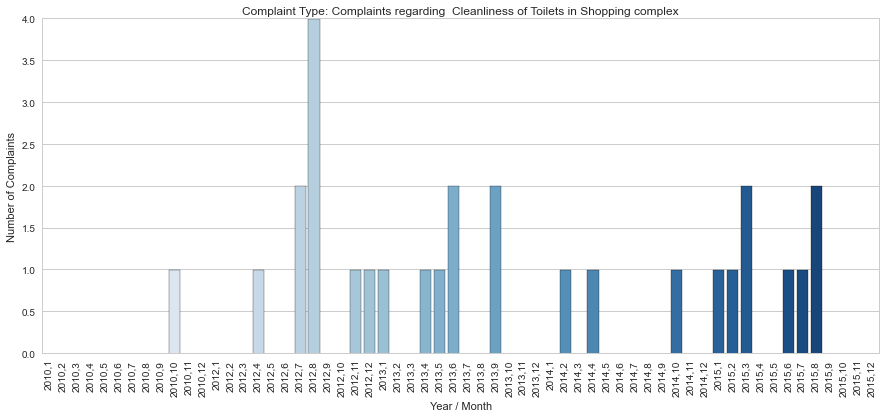

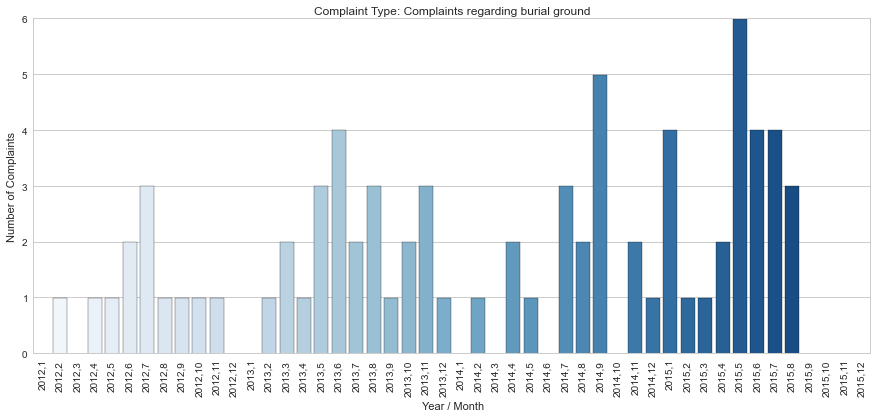

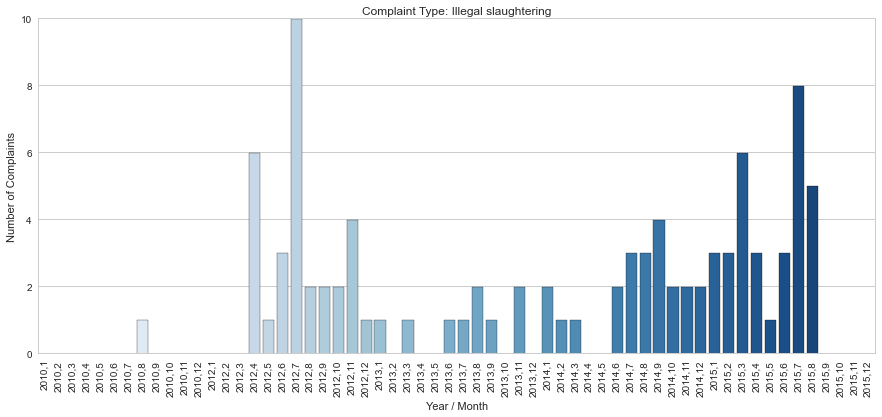

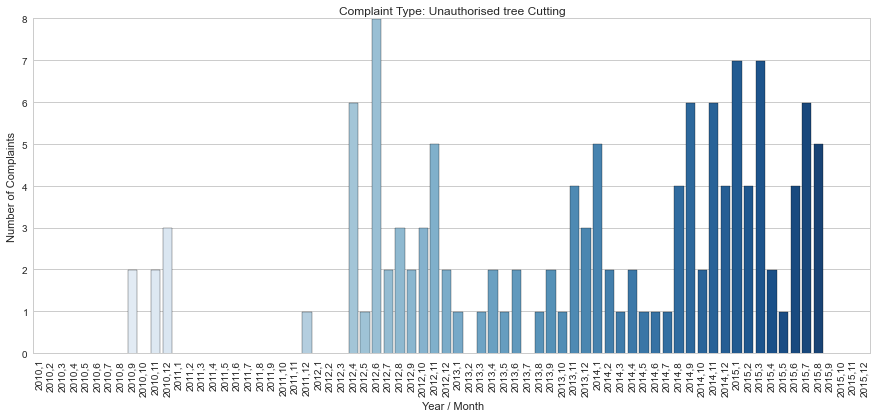

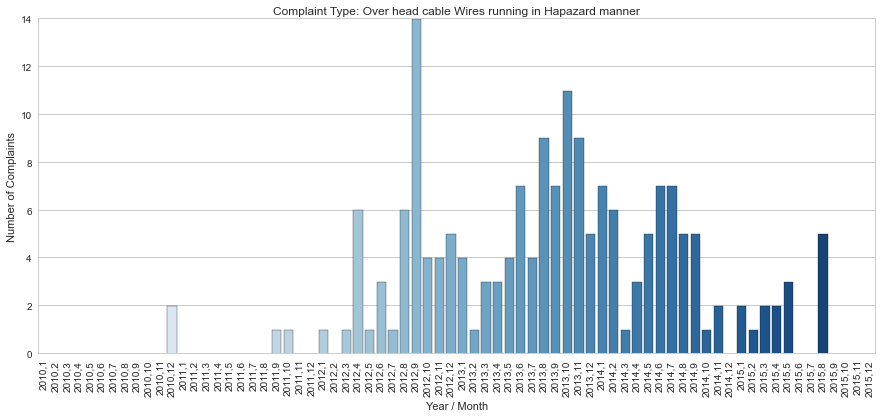

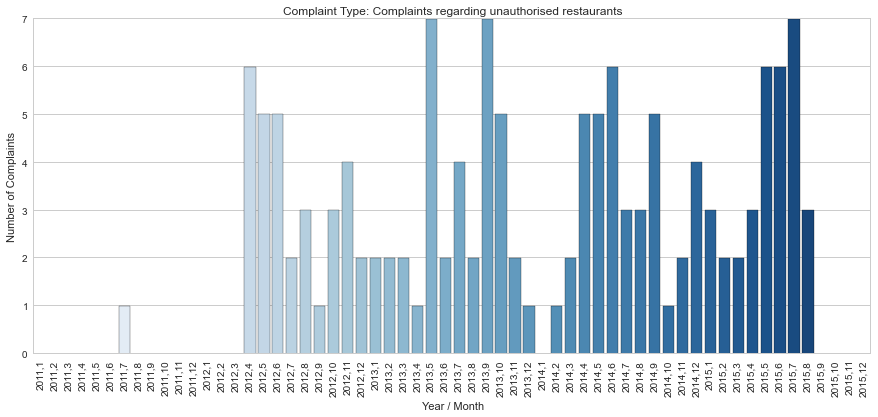

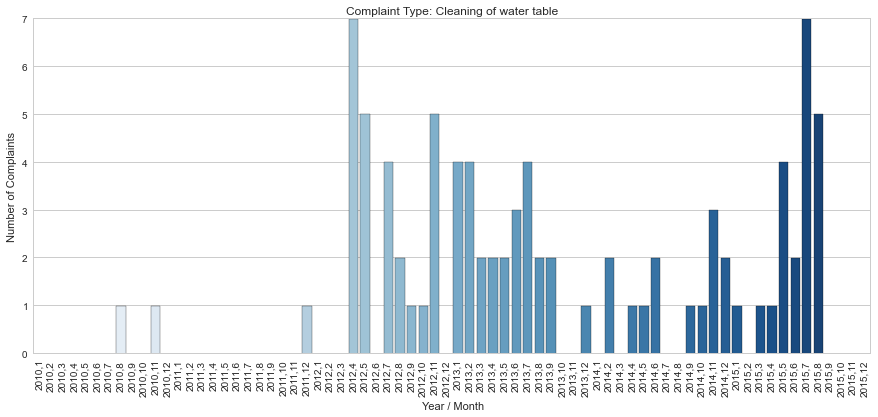

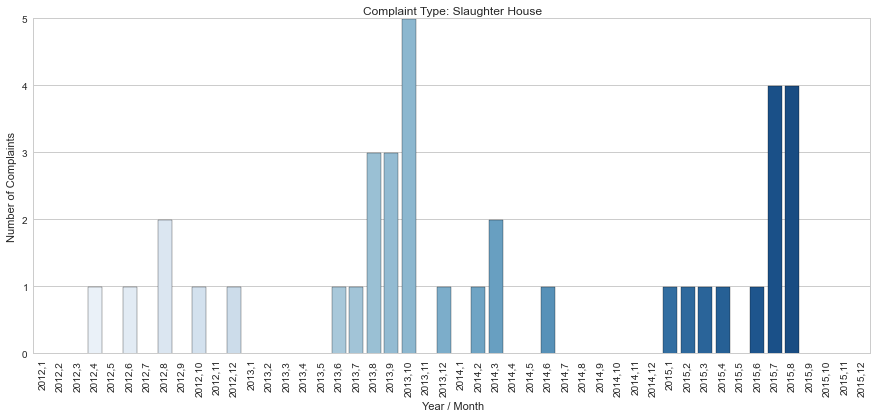

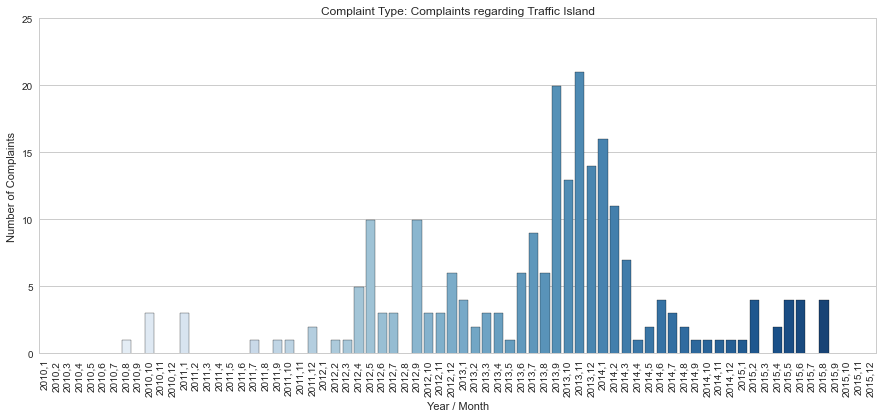

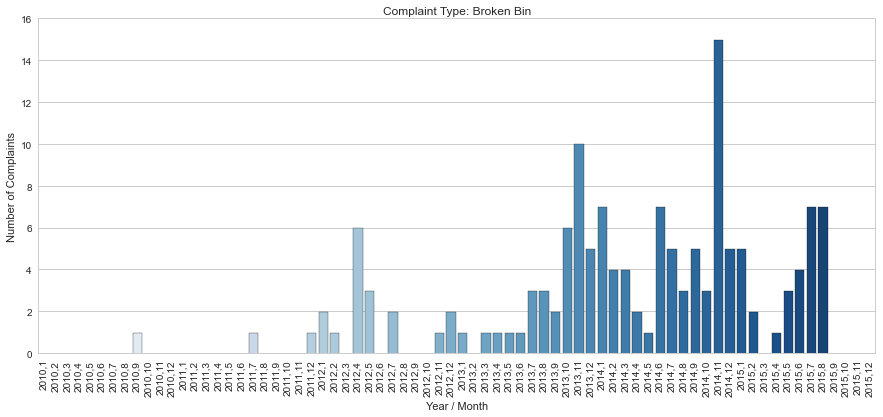

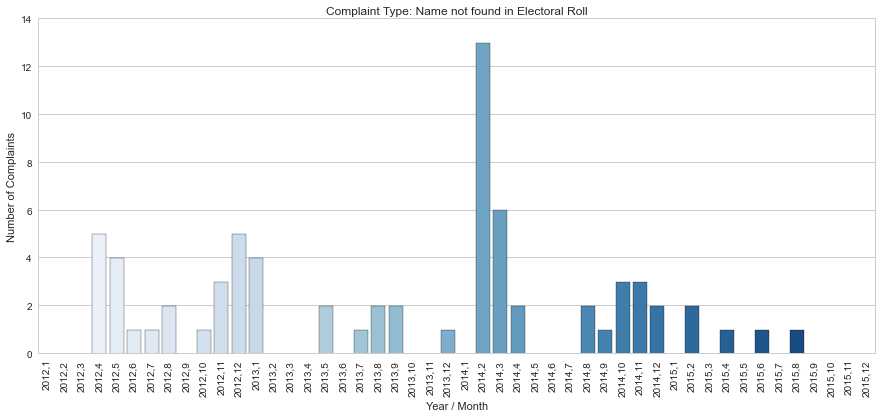

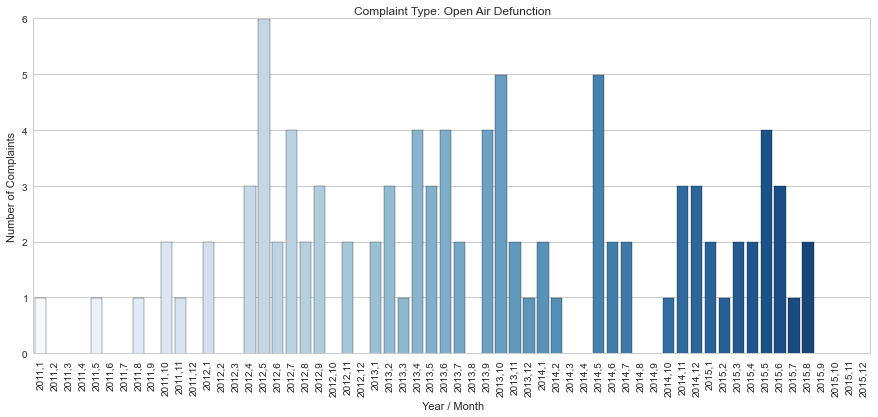

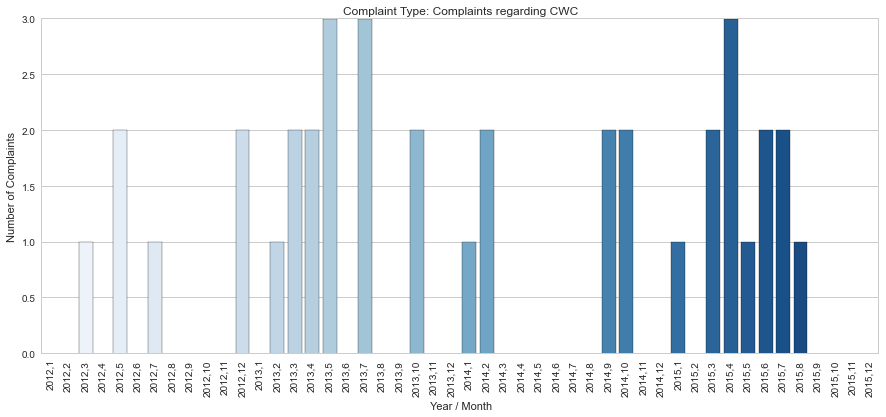

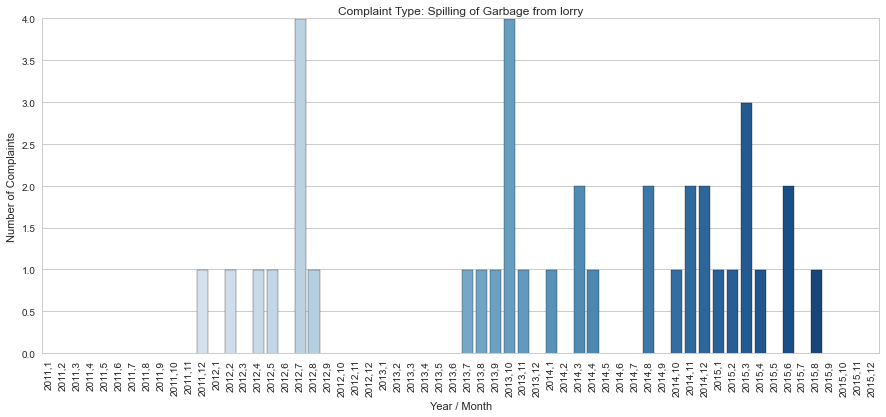

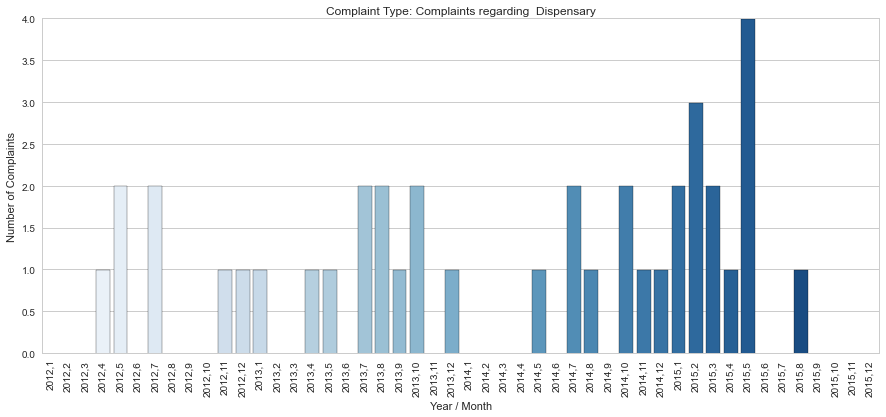

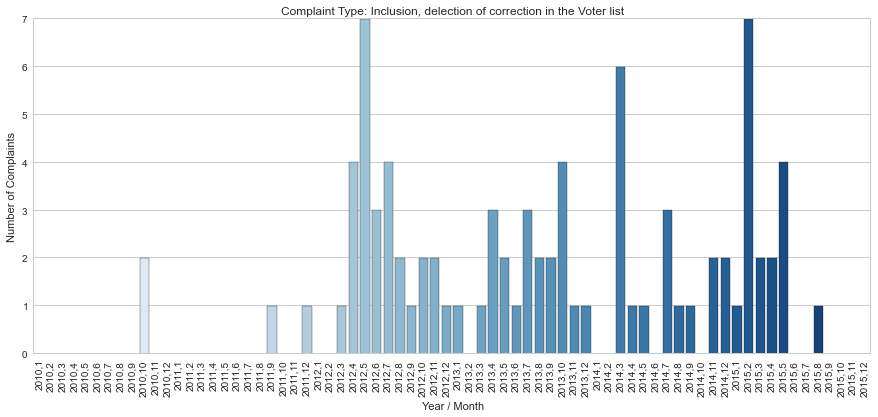

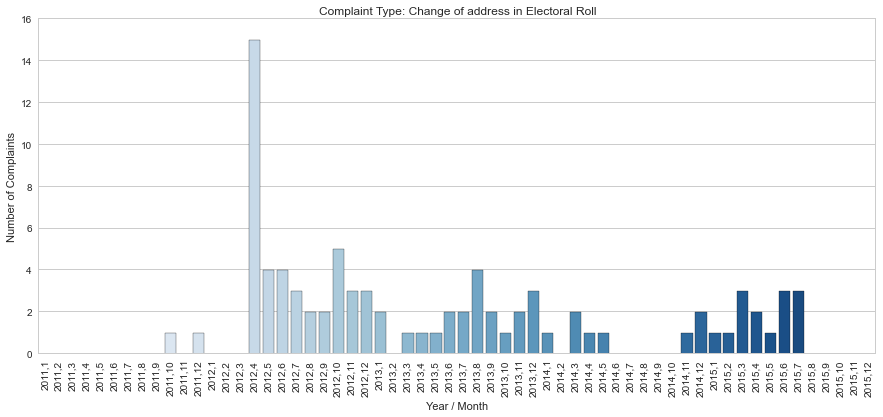

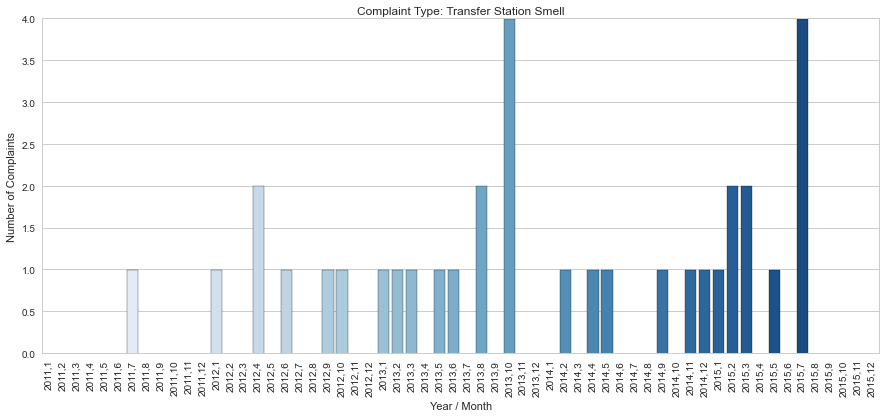

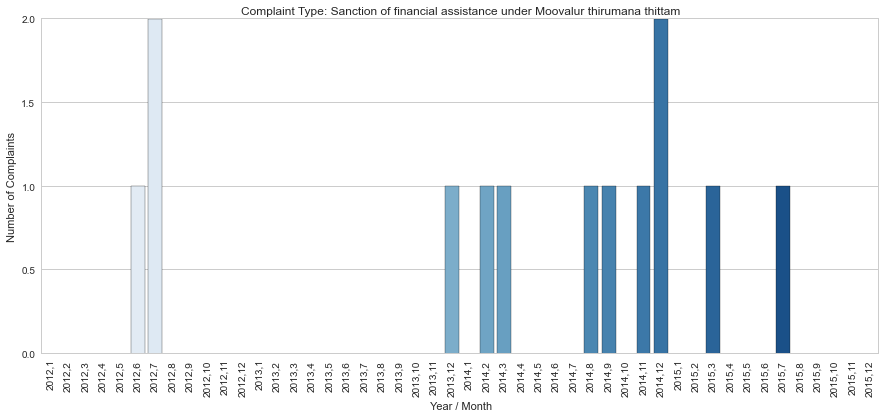

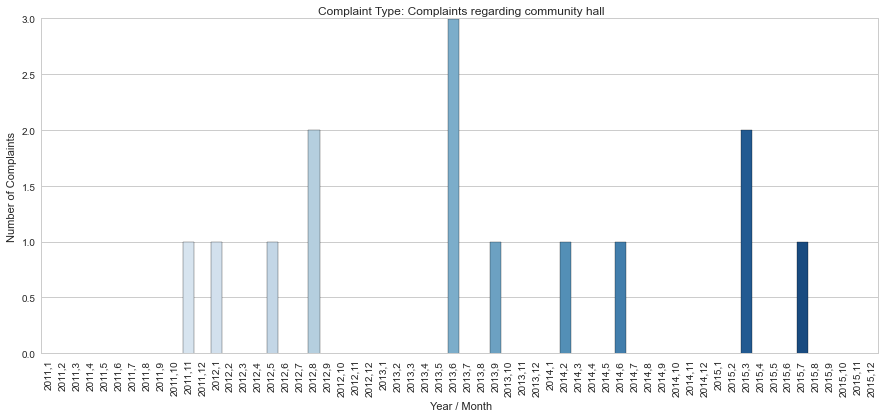

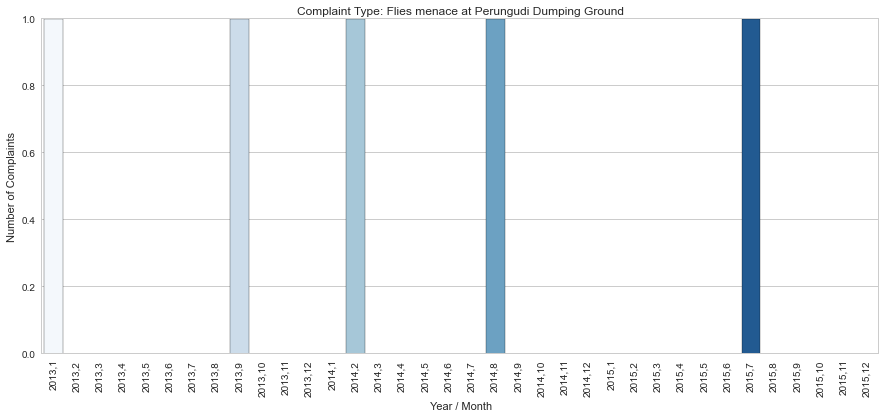

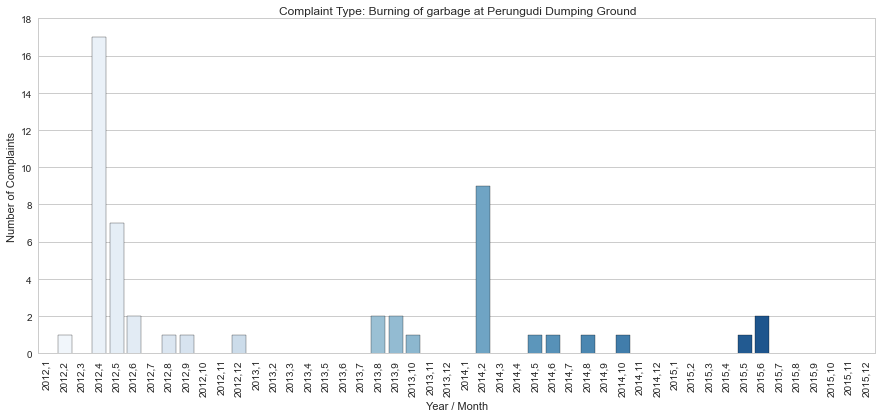

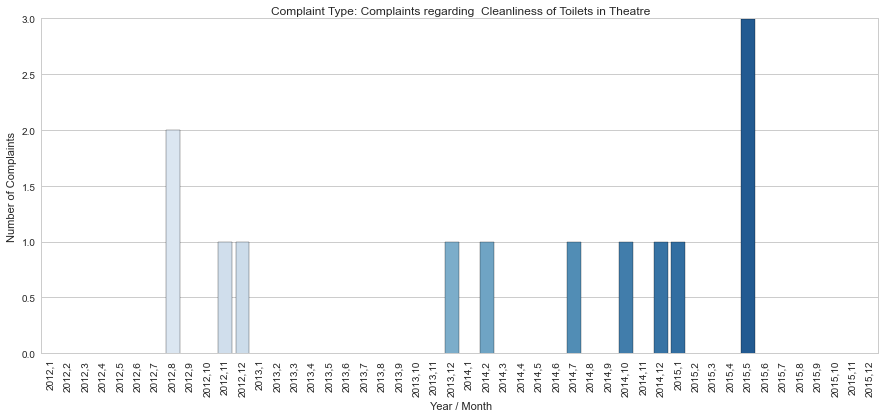

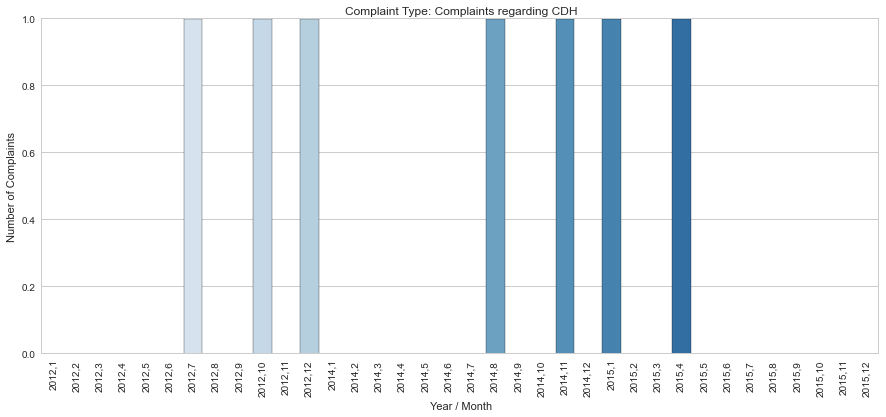

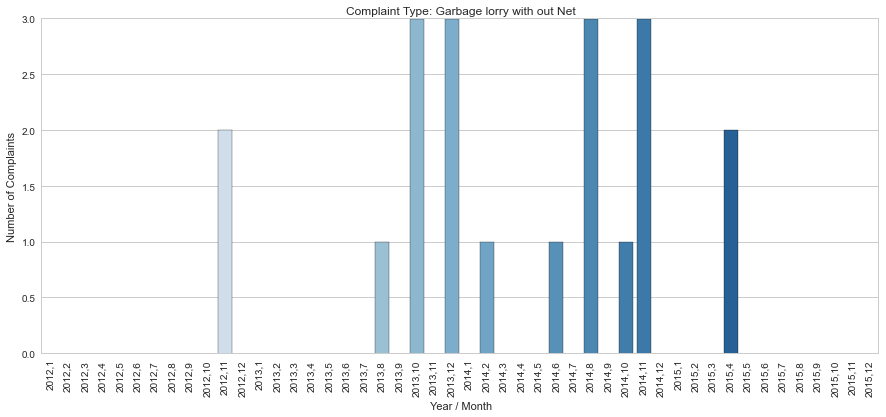

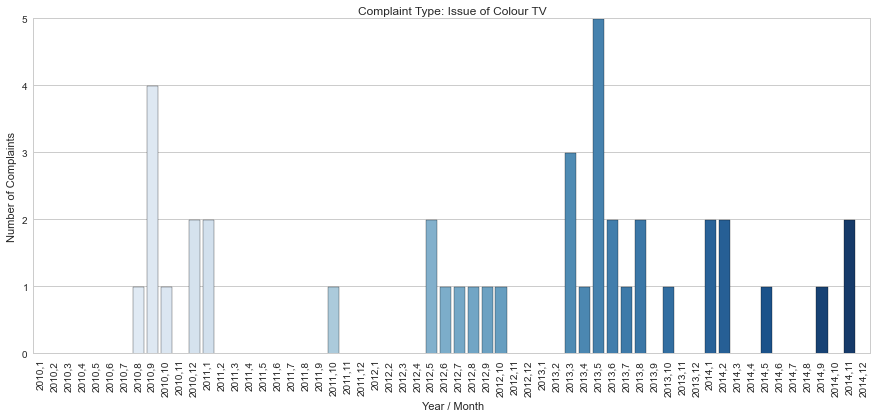

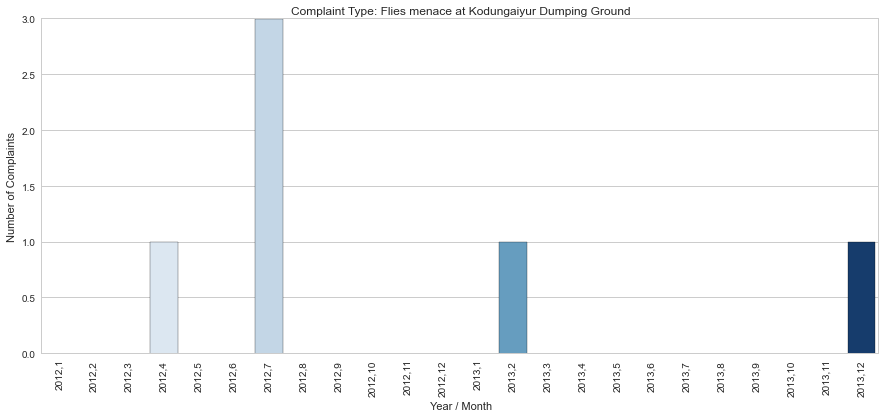

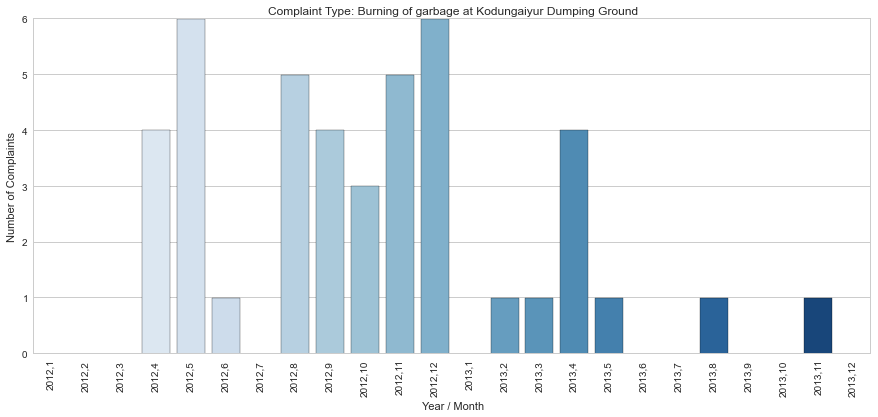

In [158]:
def plotComplaintType1(df):
    for complaintType in df["Complaint.Type"].unique():    
        counts = collections.OrderedDict()
        for year in sorted(df["Complaint.Year"].unique()):        
                slices = df[(df["Complaint.Type"] == complaintType) & (df["Complaint.Year"] == year)]
                if len(slices) == 0:
                    continue
                c = collections.Counter(slices["Complaint.Month"])        
                for month in range(1, 13):
                    counts["{},{}".format(year, month)] = c.get(month, 0)
        plt.figure(figsize=(15, 6))
        pl = sns.barplot(np.array(map(itemgetter(0), counts.items())),
                    np.array(map(itemgetter(1), counts.items())), palette="Blues")
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        plt.title("Complaint Type: {}".format(complaintType))
        plt.xlabel("Year / Month")
        plt.ylabel("Number of Complaints")
        plt.savefig("{} across years.png".format(complaintType.replace("/", "")), dpi=300)

In [195]:
undup = df.drop_duplicates(['Complaint.Type', 'Area', 'Locality', 'Street', 'Region', 'Zone', 'Ward', 'Complaint.Details', u'Email', u'Mobile', u'Complaint.Month', "Complaint.Year", u'Complaint.Day'])

In [229]:
print "Original: {}, De-duped: {}, Duplicates: {}".format(df.shape, undup.shape, df.shape[0] - undup.shape[0])

Original: (189264, 27), De-duped: (187665, 27), Duplicates: 1599


In [175]:
def saveDf(df, fileName):
    undup.to_csv(fileName, na_rep="NA", index=False, encoding="utf-8", date_format=dateFormat, quoting=csv.QUOTE_ALL)
    
# saveDf(undup, "coc_unduplicated.csv")

In [240]:
problemCategoryDictionary = df[df["Is.Resolved"] == "YES"].drop_duplicates(["Complaint.Type","Street", "Resolution.Year", "Resolution.Month", "Resolution.Day"])
print problemCategoryDictionary.shape
# saveDf(problemCategoryDictionary, "problemCategoryDictionary.csv")

(162943, 27)


In [241]:
for year in sorted(df["Complaint.Year"].unique()):
    c = collections.Counter(df[df["Complaint.Year"] == year]["Is.Resolved"])
    print year, c
    print "Percentage Resolved: {}".format(float(c["YES"]) / (c["YES"] + c["NO"]))
    

2010 Counter({'YES': 607, 'NO': 20})
Percentage Resolved: 0.968102073365
2011 Counter({'YES': 1068, 'NO': 39})
Percentage Resolved: 0.964769647696
2012 Counter({'YES': 18513, 'NO': 540})
Percentage Resolved: 0.971658006613
2013 Counter({'YES': 46409, 'NO': 1266})
Percentage Resolved: 0.973445201888
2014 Counter({'YES': 61193, 'NO': 4798})
Percentage Resolved: 0.927293115728
2015 Counter({'YES': 46171, 'NO': 8640})
Percentage Resolved: 0.842367408002
